In [1]:
import pandas as pd
import re
import random
import ast
import numpy as np
import scipy.stats as stats 
from scipy.spatial import distance
import statsmodels.stats.multitest as multitest

from statistics import mode
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.graph_objects as go
import os, glob
import sys
import pickle
import itertools
import concurrent.futures
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import threading
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
import queue
from collections import defaultdict 

from stargazer.stargazer import Stargazer, LineLocation

from tqdm import tqdm

from exhaustive_search_tools import *

plt.rcParams["font.family"] = "Times New Roman"

import warnings
warnings.filterwarnings("ignore")

# Read in the data

In [2]:
full_multi_task_data = pd.read_csv('all_multi_task_wave_data.txt')

In [3]:
full_multi_task_data = full_multi_task_data.rename(columns = {"task": "task_name"})

In [4]:
# set the score to the best score across repeated attempts, in cases where it saved multiple times
full_multi_task_data = full_multi_task_data.groupby('stageId').apply(lambda x: x.loc[x['score'].idxmax()]).reset_index(drop=True)

In [5]:
# task map
task_map = pd.read_csv('../features/task-mapping/task_map.csv')
task_map = task_map.rename(columns = {"task": "task_name"})

In [6]:
task_name_mapping = {
    "Sudoku": "Sudoku",
    "Moral Reasoning": "Moral Reasoning (Disciplinary Action Case)",
    "Wolf Goat Cabbage": "Wolf, goat and cabbage transfer",
    "Guess the Correlation": "Guessing the correlation",
    "Writing Story": "Writing story",
    "Room Assignment": "Room assignment task",
    "Allocating Resources": "Allocating resources to programs",
    "Divergent Association": "Divergent Association Task",
    "Word Construction": "Word construction from a subset of letters",
    "Whac a Mole": "Whac-A-Mole",
    "Random Dot Motion": "Random dot motion",
    "Recall Association": "Recall association",
    "Recall Word Lists": "Recall word lists",
    "Typing": "Typing game",
    "Unscramble Words": "Unscramble words (anagrams)",
    "WildCam": "Wildcam Gorongosa (Zooniverse)",
    "Advertisement Writing": "Advertisement writing",
    "Putting Food Into Categories": "Putting food into categories"
}

task_map = task_map.rename(
    columns = {
        "Q1concept_behav": "Conceptual-Behavioral",
        "Q3type_1_planning": "Type 1 (Planning)",
        "Q4type_2_generate": "Type 2 (Generate)",
        "Q6type_5_cc": "Type 5 (Cognitive Conflict)",
        "Q7type_7_battle": "Type 7 (Battle)",
        "Q8type_8_performance": "Type 8 (Performance)",
        "Q9divisible_unitary": "Divisible-Unitary",
        "Q10maximizing": "Maximizing",
        "Q11optimizing": "Optimizing",
        "Q13outcome_multip": "Outcome Multiplicity",
        "Q14sol_scheme_mul": "Solution Scheme Multiplicity",
        "Q15dec_verifiability": "Decision Verifiability",
        "Q16shared_knowledge": "Shared Knowledge",
        "Q17within_sys_sol": "Within-System Solution",
        "Q18ans_recog": "Answer Recognizability",
        "Q19time_solvability": "Time Solvability",
        "Q20type_3_type_4": "Type 3 and Type 4 (Objective Correctness)",
        "Q22confl_tradeoffs": "Conflicting Tradeoffs",
        "Q23ss_out_uncert": "Solution Scheme Outcome Uncertainty",
        "Q24eureka_question": "Eureka Question",
        "Q2intel_manip_1" : "Intellectual-Manipulative",
        "Q21intellective_judg_1" : "Intellective-Judgmental",
        "Q5creativity_input_1" : "Creativity Input",
        "Q25_type6_mixed_motive" : "Type 6 (Mixed-Motive)"
    }
)

In [7]:
full_multi_task_data.loc[:, "task_name"] = full_multi_task_data["task_name"].replace(task_name_mapping)

In [8]:
task_cols_to_use = task_map.drop(["task_name", "Type 6 (Mixed-Motive)"], axis = 1).columns

In [9]:
# merge the multi-task data with the task map
full_multi_task_data = pd.merge(left = full_multi_task_data, right = task_map, on = "task_name", how = "left")

In [10]:
communication_features = pd.read_csv("./tpm_outputs/conv/full_multi_task_messages_conversation_level.csv")
communication_features = communication_features.rename(columns={"conversation_num": "stageId"})
communication_features.columns
communication_features = communication_features.drop(columns = ['speaker_nickname', 'message',
       'timestamp', 'message_original', 'message_lower_with_punc'], axis = 1)

In [11]:
COMMS_DVS = ["turn_taking_index", "gini_coefficient_sum_num_messages", "sum_num_messages", "average_positive_bert", "team_burstiness"]

# Final Cleaned Datasets

## Task Sets: (1) Wave 1 Only; (2) All 20 Tasks
- `team_multi_task_wave1`
- `team_multi_task_full`

## Communication Features
We examine 5 communication features:
- Turn-Taking
- Gini Coefficient
- Total Number of Messages
- Positivity
- Burstiness

When analyzed in the context of the two different task sets, we get:

- `team_multi_task_comms_wave1`
- `team_multi_task_comms_full`

In [12]:
team_multi_task_full = full_multi_task_data[full_multi_task_data["playerCount"]>1]
print(len(team_multi_task_full))

3486


In [13]:
team_multi_task_wave1 = team_multi_task_full[team_multi_task_full["wave"]==1]
print(len(team_multi_task_wave1))

1772


In [14]:
team_multi_task_comms_full = pd.merge(communication_features, team_multi_task_full, on = "stageId", how = "inner")
print(len(team_multi_task_comms_full))

1858


In [15]:
team_multi_task_comms_wave1 = pd.merge(communication_features, team_multi_task_wave1, on = "stageId", how = "inner")
print(len(team_multi_task_comms_wave1))

1021


In [16]:
# Design decision: Drop all cases where the communication features are missing
team_multi_task_comms_full.dropna(subset = COMMS_DVS, inplace = True)
team_multi_task_comms_wave1.dropna(subset = COMMS_DVS, inplace = True)
print(len(team_multi_task_comms_full))
print(len(team_multi_task_comms_wave1))

1661
928


## Add in Composition Features

In [17]:
players_per_stage = team_multi_task_full[["stageId", "playerIds"]]

In [18]:
players_1 = pd.read_csv('players_wave1_epoch1.csv')
players_2 = pd.read_csv('players_wave1_epoch2.csv')
players_wave2 = pd.read_csv('players_wave_2.csv')
players_wave3 = pd.read_csv('players_wave_3.csv')

players = pd.concat([players_1, players_2, players_wave2, players_wave3])
player_workerIds = players[["_id", "id"]].dropna().rename(columns = {"_id": "playerId", "id": "WorkerId"})
# parse out the first part of WorkerId
player_workerIds["WorkerId"] = player_workerIds["WorkerId"].str.split(" ").str[0]

In [19]:
# match playerIds to players_per_stage based on whether data.playerIds CONTAINS the playerId
stage_id_to_player_and_worker = pd.DataFrame(columns=["stageId", "playerId", "WorkerId"])

# Use tqdm to create a progress bar for the loop
for player in tqdm(player_workerIds["playerId"], desc="Matching playerIds"):
    stages_played = players_per_stage[players_per_stage["playerIds"].str.contains(player)].copy()

    if len(stages_played) > 0:
        # Set "playerId" column to the player's id
        stages_played["playerId"] = player
        # Get workerId of player
        workerId = player_workerIds.loc[player_workerIds["playerId"] == player, "WorkerId"].values[0]
        # Set "WorkerId" column to the player's id
        stages_played["WorkerId"] = workerId
        new_player_rows = stages_played[["stageId", "playerId", "WorkerId"]]
        stage_id_to_player_and_worker = pd.concat([stage_id_to_player_and_worker, new_player_rows], axis=0)

Matching playerIds: 100%|██████████| 2839/2839 [00:02<00:00, 1265.92it/s]


In [20]:
# heres the information we have about all the workers
panel = pd.read_csv('individuals.csv')

In [21]:
panel_filtered = panel[["WorkerId", "CRT", "RME"]]

In [22]:
individual_workers_by_stageId = pd.merge(left = stage_id_to_player_and_worker, right = panel_filtered, on = "WorkerId", how = "left")
composition_by_stageId = individual_workers_by_stageId[["stageId", "CRT", "RME"]].groupby("stageId").mean().reset_index()

# Design decision: Drop cases where we don't have information on the participants.
# many of these are actually test datapoints (e.g., Mark and Eric)
print("Dropping " + str(len(composition_by_stageId) - len(composition_by_stageId.dropna())) + " rows.")
composition_by_stageId = composition_by_stageId.dropna()

Dropping 28 rows.


### Let's add in the composition features. 
A few teams don't have valid composition data, so let's separately store the dataframe and get a sense of what the differences are.

In [23]:
team_composition_by_stageId = composition_by_stageId[composition_by_stageId['stageId'].isin(team_multi_task_full['stageId'])]

In [24]:
# merge the composition with the rest of the data
team_multi_task_full_with_composition = pd.merge(team_multi_task_full, team_composition_by_stageId, on = "stageId", how = "inner")
team_multi_task_wave1_with_composition = pd.merge(team_multi_task_wave1, team_composition_by_stageId, on = "stageId", how = "inner")
team_multi_task_comms_full_with_composition = pd.merge(team_multi_task_comms_full, team_composition_by_stageId, on = "stageId", how = "inner")
team_multi_task_comms_wave1_with_composition = pd.merge(team_multi_task_comms_wave1, team_composition_by_stageId, on = "stageId", how = "inner")

In [25]:
print("Difference in # Rows for Multi-Task (Full; 20 Tasks)")
print(len(team_multi_task_full) - len(team_multi_task_full_with_composition))
print("Difference in # Rows for Multi-Task (Wave 1; 10 Tasks)")
print(len(team_multi_task_wave1) - len(team_multi_task_wave1_with_composition))
print("Difference in # Rows for Multi-Task w/ Communication (Wave 1; 10 Tasks)")
print(len(team_multi_task_comms_full) - len(team_multi_task_comms_full_with_composition))
print("Difference in # Rows for Multi-Task w/ Communication (Wave 1; 10 Tasks)")
print(len(team_multi_task_comms_wave1) - len(team_multi_task_comms_wave1_with_composition))

Difference in # Rows for Multi-Task (Full; 20 Tasks)
28
Difference in # Rows for Multi-Task (Wave 1; 10 Tasks)
28
Difference in # Rows for Multi-Task w/ Communication (Wave 1; 10 Tasks)
6
Difference in # Rows for Multi-Task w/ Communication (Wave 1; 10 Tasks)
6


### Add Interactions Between Composition and Task Features

In [26]:
def get_task_composition_interactions(df):
    for task_col in task_cols_to_use:
        # intersect with team size
        task_col_x_teamsize = df[task_col]*df["playerCount"]
        df.loc[:, task_col + " x playerCount"] = task_col_x_teamsize

        # intersect with CRT
        task_col_x_CRT = df[task_col]*df["CRT"]
        df.loc[:, task_col + " x CRT"] = task_col_x_CRT

        # intersect with RME
        task_col_x_RME = df[task_col]*df["RME"]
        df.loc[:, task_col + " x RME"] = task_col_x_RME
    
    return df

In [27]:
team_multi_task_full_with_composition = get_task_composition_interactions(team_multi_task_full_with_composition)
team_multi_task_wave1_with_composition = get_task_composition_interactions(team_multi_task_wave1_with_composition)
team_multi_task_comms_full_with_composition = get_task_composition_interactions(team_multi_task_comms_full_with_composition)
team_multi_task_comms_wave1_with_composition = get_task_composition_interactions(team_multi_task_comms_wave1_with_composition)

In [28]:
# get the relevant columns so that we can select them easily
task_cols_and_derivatives = list(set(list(task_cols_to_use) + [col for col in team_multi_task_full_with_composition.columns if "x" in col]))
all_features_and_interactions = task_cols_and_derivatives + ["CRT", "RME", "playerCount"] + ["High", "Medium"]
controls = ["High", "Medium"] # these are dummy variables for the high and medium conditions; we won't standardize them

## Additional Preprocessing
- Standardize all task columns
- Standardize all composition variables
- Standardize all interaction terms
- Standardize all dependent variables

In [29]:
cols_to_use = ["score"] + list(task_cols_to_use)
cols_to_use_with_comms = COMMS_DVS + ["score"] + list(task_cols_to_use)

In [30]:
# these are our dataframes *without* composition or interactions
team_multi_task_full[cols_to_use] = StandardScaler().fit_transform(team_multi_task_full[cols_to_use])
team_multi_task_wave1[cols_to_use] = StandardScaler().fit_transform(team_multi_task_wave1[cols_to_use])
team_multi_task_comms_full[cols_to_use_with_comms] = StandardScaler().fit_transform(team_multi_task_comms_full[cols_to_use_with_comms])
team_multi_task_comms_wave1[cols_to_use_with_comms] = StandardScaler().fit_transform(team_multi_task_comms_wave1[cols_to_use_with_comms])

# these are our dataframes *with* composition and interactions
team_multi_task_full_with_composition[all_features_and_interactions + ["score"]] = StandardScaler().fit_transform(team_multi_task_full_with_composition[all_features_and_interactions + ["score"]])
team_multi_task_wave1_with_composition[all_features_and_interactions + ["score"]] = StandardScaler().fit_transform(team_multi_task_wave1_with_composition[all_features_and_interactions + ["score"]])
team_multi_task_comms_full_with_composition[all_features_and_interactions + COMMS_DVS + ["score"]] = StandardScaler().fit_transform(team_multi_task_comms_full_with_composition[all_features_and_interactions + COMMS_DVS + ["score"]])
team_multi_task_comms_wave1_with_composition[all_features_and_interactions + COMMS_DVS + ["score"]] = StandardScaler().fit_transform(team_multi_task_comms_wave1_with_composition[all_features_and_interactions + COMMS_DVS + ["score"]])

Get some basic descriptive statistics

In [31]:
print("Total number of observations:")
print(len(team_multi_task_wave1))

print("Total number of unique teams:")
print(len(team_multi_task_wave1["playerIds"].drop_duplicates()))

team_multi_task_wave1[["playerCount", "task_name"]].groupby("task_name").value_counts()

Total number of observations:
1772
Total number of unique teams:
125


task_name                                   playerCount
Allocating resources to programs            3               93
                                            6               78
Divergent Association Task                  3               77
                                            6               75
Guessing the correlation                    3              100
                                            6               83
Moral Reasoning (Disciplinary Action Case)  3               93
                                            6               81
Room assignment task                        3              105
                                            6               81
Sudoku                                      3               87
                                            6               81
Whac-A-Mole                                 3              115
                                            6               78
Wolf, goat and cabbage transfer             3              117

In [32]:
print("Total number of observations in chat level data (Wave 1):")
print(len(team_multi_task_comms_wave1))

print("Total number of unique teams in chat level data:")
print(len(team_multi_task_comms_wave1["playerIds"].drop_duplicates()))

Total number of observations in chat level data (Wave 1):
928
Total number of unique teams in chat level data:
110


In [33]:
print("Total number of observations:")
print(len(team_multi_task_full))

print("Total number of unique teams:")
print(len(team_multi_task_full["playerIds"].drop_duplicates()))

team_multi_task_full[["playerCount", "task_name"]].groupby("task_name").value_counts()

Total number of observations:
3486
Total number of unique teams:
240


task_name                                   playerCount
Advertisement writing                       3               99
                                            6               83
Allocating resources to programs            3               93
                                            6               78
Divergent Association Task                  3               77
                                            6               75
Guessing the correlation                    3              100
                                            6               83
Logic Problem                               3               87
                                            6               75
Moral Reasoning (Disciplinary Action Case)  3               93
                                            6               81
Putting food into categories                3               98
                                            6               84
Random dot motion                           3               87

# Set up "Us versus McGrath"

In [34]:
mcgrath_colnames = [col for col in task_map.columns if "Type" in col]
# remove type 6, as it is not relevant for our data
mcgrath_colnames.remove('Type 6 (Mixed-Motive)')

In [35]:
def get_mcgrath_categorical(df):
    mcgrath_categorical_buckets = {}
    
    # first, convert everything into one of mcgrath's categories
    for i in range(len(df)):
        task_vec_mcgrath = df[mcgrath_colnames].iloc[i][1:]
        task_name = df.iloc[i]["task_name"]
        task_type = task_vec_mcgrath.idxmax()
        type_val = task_vec_mcgrath[task_type]
        if task_type == "Type 3 and Type 4 (Objective Correctness)":
            task_type = "Type 3 (Intellective)" if type_val > 0.5 else "Type 4 (Decision-Making)"

        mcgrath_categorical_buckets[task_name] = task_type
        
    mcgrath_df = pd.DataFrame({
        "task_name": mcgrath_categorical_buckets.keys(),
        "mcgrath_category": mcgrath_categorical_buckets.values()
    })

    mcgrath_df_categorical = pd.concat([mcgrath_df["task_name"], pd.get_dummies(mcgrath_df["mcgrath_category"], dtype= int).add_suffix('_cat')], axis = 1)

    mcgrath_categorical = list(mcgrath_df_categorical.columns)
    mcgrath_categorical.remove("task_name")
    
    # after calculating the categories, return the dataframe
    return (df.merge(mcgrath_df_categorical, on = "task_name"), mcgrath_categorical)

In [36]:
# OUR FOUR DATASETS ARE:
# team_multi_task_full, team_multi_task_wave1
# team_multi_task_comms_full, team_multi_task_comms_wave1

def get_mcgrath_comparisons(datasets, dvs):
    
    comparison_dict_list = [{} for i in range(len(datasets))]
    
    for i, dataset in enumerate(datasets):
        comparison_dict = comparison_dict_list[i]
        
        dataset, mcgrath_categorical = get_mcgrath_categorical(dataset)

        for dv in dvs:
            comparison_dict[dv] = {}
            comparison_dict[dv]["mcgrath_continuous"] = get_q2(dataset[[dv, "task_name"]], dataset[mcgrath_colnames + ["playerCount", "Low", "Medium", "task_name"]], estimator = LinearRegression())
            comparison_dict[dv]["mcgrath_categorical"] = get_q2(dataset[[dv, "task_name"]], dataset[mcgrath_categorical + ["playerCount", "Low", "Medium", "task_name"]], estimator = LinearRegression())
            comparison_dict[dv]["all_features"] = get_q2(dataset[[dv, "task_name"]], dataset[list(task_cols_to_use) + ["playerCount", "Low", "Medium", "task_name"]], estimator = LinearRegression())
            
    return comparison_dict_list

Our dictionaries of looking at McGrath versus the rest:
1. `mcgrath_comparisons_full`
2. `mcgrath_comparisons_wave1`
3. `mcgrath_comparisons_conv_full`
4. `mcgrath_comparisons_conv_wave1`

In [37]:
mcgrath_comparisons_full, mcgrath_comparisons_wave1 = get_mcgrath_comparisons([team_multi_task_full, team_multi_task_wave1], ["score"])

In [38]:
mcgrath_comparisons_conv_full, mcgrath_comparisons_conv_wave1 = get_mcgrath_comparisons([team_multi_task_comms_full, team_multi_task_comms_wave1], COMMS_DVS)

In [39]:
# example of looking at the dictionary
mcgrath_comparisons_full

{'score': {'mcgrath_continuous': 0.1279738531043504,
  'mcgrath_categorical': 0.22713504284140085,
  'all_features': -1.8457581917629178e+24}}

In [40]:
mcgrath_comparisons_conv_full

{'turn_taking_index': {'mcgrath_continuous': -0.10086506025107655,
  'mcgrath_categorical': -0.30942262913147345,
  'all_features': -2.935734540001007e+24},
 'gini_coefficient_sum_num_messages': {'mcgrath_continuous': 0.10584945342008023,
  'mcgrath_categorical': -0.01720721968120187,
  'all_features': -5.876082187551697e+24},
 'sum_num_messages': {'mcgrath_continuous': 0.08816867179049426,
  'mcgrath_categorical': 0.021326173357139155,
  'all_features': -1.0596377409687522e+23},
 'average_positive_bert': {'mcgrath_continuous': -0.0709927901951859,
  'mcgrath_categorical': -0.1238947362617091,
  'all_features': -1.2271784278334418e+25},
 'team_burstiness': {'mcgrath_continuous': -0.009238366370673434,
  'mcgrath_categorical': -0.01338157177536825,
  'all_features': -1.1658863101055347e+25}}

# Complete Exhaustive Search if Dataframe is Incomplete

In [41]:
def check_and_complete_exhaustive_search(results_df, n_features, dv, is_full, filename):
    
    # print(filename)
    # first check the number that we expect to have
    column_choice_combinations = list(itertools.combinations(task_cols_to_use, n_features))
    column_choice_combinations_str = [str(item) for item in column_choice_combinations]

    # print("number of combos expected: " + str(len(column_choice_combinations)))
    # print("length of dataframe: " + str(len(results_df)))

    num_combinations = len(column_choice_combinations)

    # if we have the right number, we're done
    if(len(results_df) == num_combinations):
        return results_df
    elif(len(results_df) > num_combinations):
        print("too many results, dropping duplicates...")
        results_df = pd.read_csv(filename).drop_duplicates()
        results_df = results_df[results_df["selected_task_cols"].isin(set(column_choice_combinations_str))]
        results_df.to_csv(filename, index = False)

        return results_df
    else:
        print("not enough results...")

        # if not, we need to complete the exhaustive search
        completed_combos_set = set(results_df["selected_task_cols"])
        remaining_combos = set(column_choice_combinations_str).difference(completed_combos_set)

        if dv == "score":
            # this is the dataset without conversational features
            if is_full:
                data = team_multi_task_full
            else:
                data = team_multi_task_wave1
        else:
            # this is the dataset WITH conversational features
            if is_full:
                data = team_multi_task_comms_full
            else:
                data = team_multi_task_comms_wave1

        # then we fill out the rest of the features one at a time
        with open(filename, 'a', newline='') as csvfile:
            fieldnames = ['selected_task_cols', 'q2']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            
            # get the q2 and write the features in a single-threaded way
            for combination in tqdm(remaining_combos, desc="Processing Combinations for " + filename):
                combination = ast.literal_eval(combination) # as the combination is a string
                q2 = process_combination(combination, data, dv, filename)                    
                writer.writerow({'selected_task_cols': combination, 'q2': q2})

        # ensure that the CSV doesn't contain any duplicates
        results_df = pd.read_csv(filename).drop_duplicates()
        results_df.to_csv(filename, index = False)

        return results_df

# Main Visuals

In [42]:
def get_robust_se(model):
    # Obtain robust covariance results
    robust_cov = model.get_robustcov_results(cov_type='HC3')  # Heteroskedasticity robust covariance
    # Extract standard errors and convert to a Pandas Series with coefficient names as index
    robust_se = pd.Series(robust_cov.bse, index=model.params.index)
    return robust_se

def correct_p_values(task_lm, task_crt_lm, task_rme_lm, task_playercount_lm, giant_lm):
    # Get robust standard errors for each model
    task_lm.bse_corrected = get_robust_se(task_lm)
    task_crt_lm.bse_corrected = get_robust_se(task_crt_lm)
    task_rme_lm.bse_corrected = get_robust_se(task_rme_lm)
    task_playercount_lm.bse_corrected = get_robust_se(task_playercount_lm)
    giant_lm.bse_corrected = get_robust_se(giant_lm)

    # Corrected p-values
    p_values = [task_lm.pvalues, task_crt_lm.pvalues, task_rme_lm.pvalues, task_playercount_lm.pvalues, giant_lm.pvalues]
    all_p_values = [p for sublist in p_values for p in sublist]
    
    # Apply Benjamini-Hochberg correction
    rejected, corrected_p_values, _, _ = multitest.multipletests(all_p_values, alpha=0.05, method='fdr_bh')

    len_task = len(task_lm.pvalues)
    len_task_crt = len(task_crt_lm.pvalues)
    len_task_rme = len(task_rme_lm.pvalues)
    len_task_playercount = len(task_playercount_lm.pvalues)

    corrected_p_values_task = pd.Series(corrected_p_values[:len_task], index=task_lm.pvalues.index)
    corrected_p_values_task_crt = pd.Series(corrected_p_values[len_task:len_task+len_task_crt], index=task_crt_lm.pvalues.index)
    corrected_p_values_task_rme = pd.Series(corrected_p_values[len_task+len_task_crt:len_task+len_task_crt+len_task_rme], index=task_rme_lm.pvalues.index)
    corrected_p_values_task_playercount = pd.Series(corrected_p_values[len_task+len_task_crt+len_task_rme:len_task+len_task_crt+len_task_rme+len_task_playercount], index=task_playercount_lm.pvalues.index)
    corrected_p_values_giant = pd.Series(corrected_p_values[len_task+len_task_crt+len_task_rme+len_task_playercount:], index=giant_lm.pvalues.index)

    task_lm.pvalues_corrected = corrected_p_values_task
    task_crt_lm.pvalues_corrected = corrected_p_values_task_crt
    task_rme_lm.pvalues_corrected = corrected_p_values_task_rme
    task_playercount_lm.pvalues_corrected = corrected_p_values_task_playercount
    giant_lm.pvalues_corrected = corrected_p_values_giant

    return task_lm, task_crt_lm, task_rme_lm, task_playercount_lm, giant_lm

In [43]:
def intensify_color(color, factor=0.5):
    """ Make the color more intense by scaling the RGB values. """
    color_rgb = mcolors.to_rgb(color)
    return tuple(min(1, c * factor) for c in color_rgb)

In [44]:
def plot_models(models, features_to_plot, model_names, colors, title, figsize = (8, 10), pval_thresh = 0.05, y_jitter = 1.3):
    # Create a DataFrame to organize the parameters for easier manipulation
    pvalues_corrected_df = pd.DataFrame([model.pvalues_corrected for model in models], index=model_names).filter(features_to_plot)
    params_df = pd.DataFrame([model.params for model in models], index=model_names).filter(features_to_plot)

    sorted_columns = params_df.sum().sort_values(ascending=False).index

    # order everything by smallest to largest effect size
    params_df = params_df.reindex(columns=sorted_columns)
    pvalues_corrected_df = pvalues_corrected_df.reindex(columns=sorted_columns)
    stderr_df = pd.DataFrame([model.bse for model in models], index=model_names).reindex(columns=sorted_columns)
    stderr_corrected_df = pd.DataFrame([model.bse_corrected for model in models], index=model_names).reindex(columns=sorted_columns)
    
    fig, ax = plt.subplots(figsize=figsize)
    y_positions = np.arange(len(params_df.columns)) * 10 # spread out y-positions

    #### THIS PLOTS THE REGULAR THING ###
    for i, model_name in enumerate(model_names):
        pvalues_corrected = pvalues_corrected_df.loc[model_name]
        means = params_df.loc[model_name]
        errors = stderr_df.loc[model_name]
        errors_corrected = stderr_corrected_df.loc[model_name]
        plot_color = colors[i]

        # Plot uncorrected errors with colored solid lines
        ax.errorbar(means, y_positions + i * y_jitter, xerr=errors, fmt='o', color=plot_color, capsize=1, label=f'{model_name}')# (SE Uncorrected)')

        # Plot corrected errors with gray broken lines
        ax.errorbar(means, y_positions + i * y_jitter, xerr=errors_corrected, fmt='none', color=intensify_color(plot_color, factor=0.7), capsize=1)# label=f'{model_name} (SE Corrected)')

    ### THIS GRAYS OUT THE NON-SIGNIFICANT ONES ###
    for i, model_name in enumerate(model_names):
        pvalues_corrected = pvalues_corrected_df.loc[model_name]
        means = params_df.loc[model_name]
        errors = stderr_df.loc[model_name]
        errors_corrected = stderr_corrected_df.loc[model_name]

        # Iterate over each point and plot it with its corresponding color based on p-value significance
        for j, (mean, error, error_corrected, pval) in enumerate(zip(means, errors, errors_corrected, pvalues_corrected)):
            plot_color = colors[i] if pval <= pval_thresh else 'lightgray'

            # Plot uncorrected errors with colored solid lines
            ax.errorbar(mean, y_positions[j] + i * y_jitter, xerr=error, fmt='o', color=plot_color, capsize=1)
            # Plot corrected errors with gray broken lines
            ax.errorbar(mean, y_positions[j] + i * y_jitter, xerr=error_corrected, fmt='none', color=intensify_color(plot_color, factor=0.7), capsize=1)
       
    ax.set_title(title)
    ax.set_xlabel('Coefficient Value') 
    ax.set_ylabel('Variables')  
    ax.set_yticks(y_positions + (len(models) - 1) * y_jitter / 2)  
    ax.set_yticklabels(params_df.columns, rotation=45, ha="right")  
    ax.grid(axis='x', linestyle='--', alpha=0.7) 
    if(len(models) > 1): 
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.axvline(x=0, color='r', linestyle='-') 
    plt.show()

In [45]:
def plot_q2_combination_hist(df, mcgrath_dict, col, dv, title_append = ""):
    # keep the dataframe for metrics
    df_for_metrics =  df
    # when plotting, filter the dataframe so that we don't have huge negative values
    df = df[df[col] > -10]

    plt.hist(df[col], bins=40, color="dodgerblue")

    # Vertical lines
    mean_q2 = np.mean(df_for_metrics[col]) # df for metrics is where we'll calculate the mean / max from, but we'll plot the df (in case there's a long tail)
    mcgrath_continuous = mcgrath_dict[dv]["mcgrath_continuous"]
    mcgrath_categorical = mcgrath_dict[dv]["mcgrath_categorical"]
    max_q2 = np.max(df_for_metrics[col])

    plt.axvline(mean_q2, color='salmon', linestyle='dashed', linewidth=1, label='Mean (' + str(np.round(mean_q2, 3)) + ")")
    plt.axvline(mcgrath_continuous, color='limegreen', linestyle='dashed', linewidth=1, label='Continuous McGrath (' + str(np.round(mcgrath_continuous, 3)) + ")")
    plt.axvline(mcgrath_categorical, color='cyan', linestyle='dashed', linewidth=1, label='Categorical McGrath (' + str(np.round(mcgrath_categorical, 3)) + ")")
    plt.axvline(max_q2, color='gold', linestyle='dashed', linewidth=1, label='Max (' + str(np.round(max_q2, 3)) + ")")

    # Labels and title
    plt.title(f'Q^2 for All ({len(df_for_metrics):,}) Task Column Combinations{title_append}')
    plt.ylabel('Number of Task Column Combinations With Value')
    plt.xlabel('Q^2 Value')

    # Legend
    plt.legend()

    # Show plot
    plt.show()

In [46]:
# Print likelihood ratio tests
def print_likelihood_ratio_tests(task_lm, task_crt_lm, task_rme_lm, task_playercount_lm, giant_lm):
    lr_statistic, p_value, df = task_crt_lm.compare_lr_test(task_lm)
    print("Likelihood Ratio Statistic for Task and CRT") # The likelihood ratio which is chisquare distributed with df_diff degrees of freedom.
    print(lr_statistic)
    print("p-value")
    print(p_value)

    lr_statistic, p_value, df = task_rme_lm.compare_lr_test(task_lm)
    print("Likelihood Ratio Statistic for Task and RME") # The likelihood ratio which is chisquare distributed with df_diff degrees of freedom.
    print(lr_statistic)
    print("p-value")
    print(p_value)

    lr_statistic, p_value, df = task_playercount_lm.compare_lr_test(task_lm)
    print("Likelihood Ratio Statistic for Task and PlayerCount") # The likelihood ratio which is chisquare distributed with df_diff degrees of freedom.
    print(lr_statistic)
    print("p-value")
    print(p_value)

In [47]:
comm_dv_translation = {
    "turn_taking_index": "Turn Taking Index",
    "gini_coefficient_sum_num_messages": "Gini Coefficient",
    "sum_num_messages": "Total Number of Messages",
    "average_positive_bert": "Average Message Positivity",
    "team_burstiness": "Team Burstiness"
}

In [48]:
# dictionary to store the different top features selected by the models
top_features_dict = {}

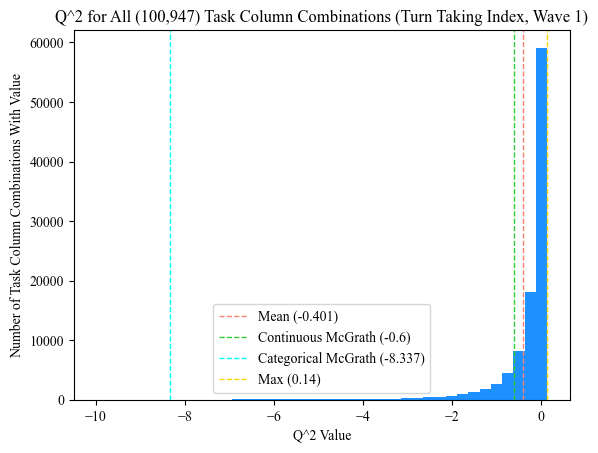

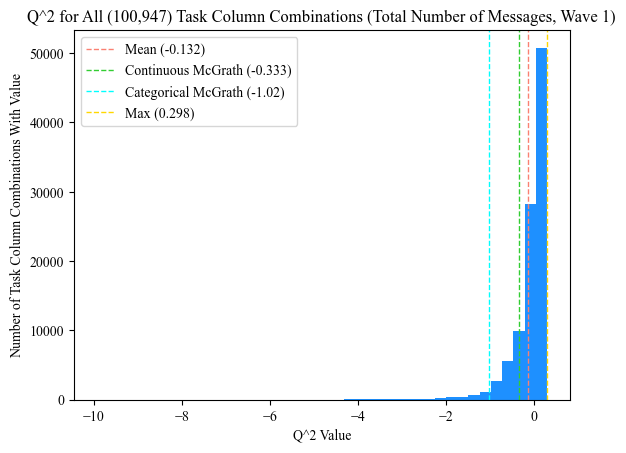

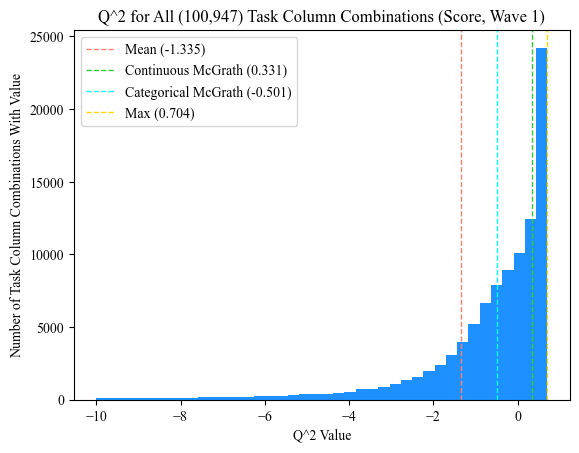

Likelihood Ratio Statistic for Task and CRT
42.760651196284016
p-value
3.7100403062044987e-07
Likelihood Ratio Statistic for Task and RME
14.247481105056067
p-value
0.046950717905697735
Likelihood Ratio Statistic for Task and PlayerCount
61.01336512387752
p-value
9.470537801430543e-11


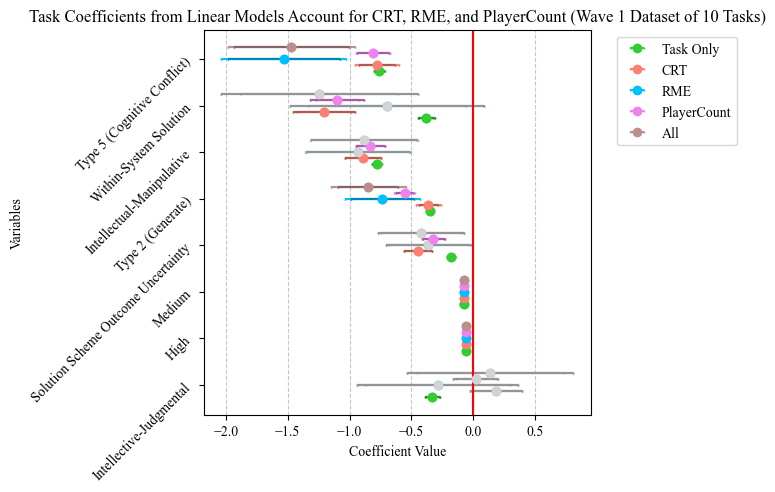

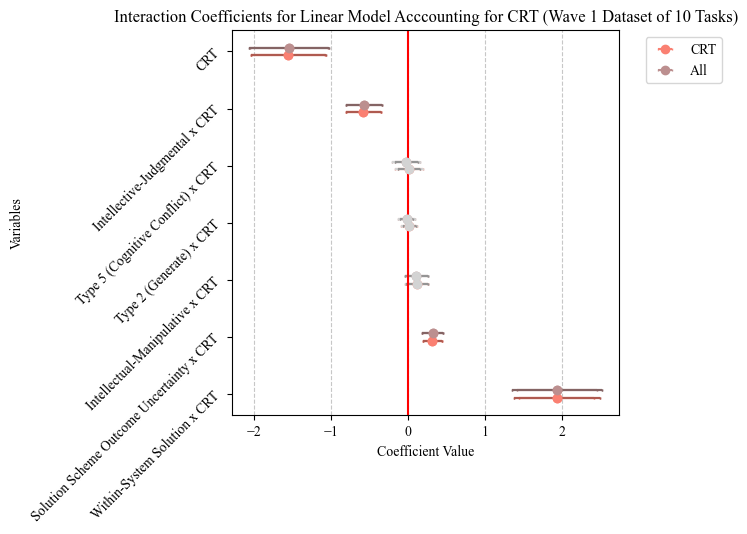

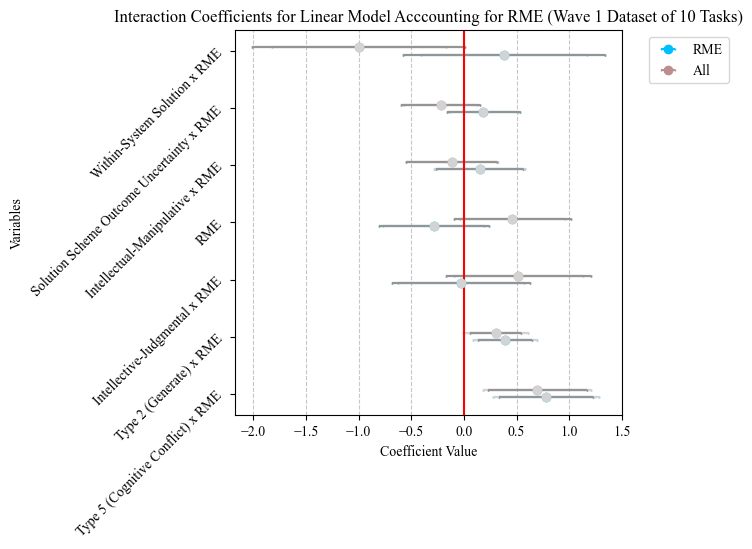

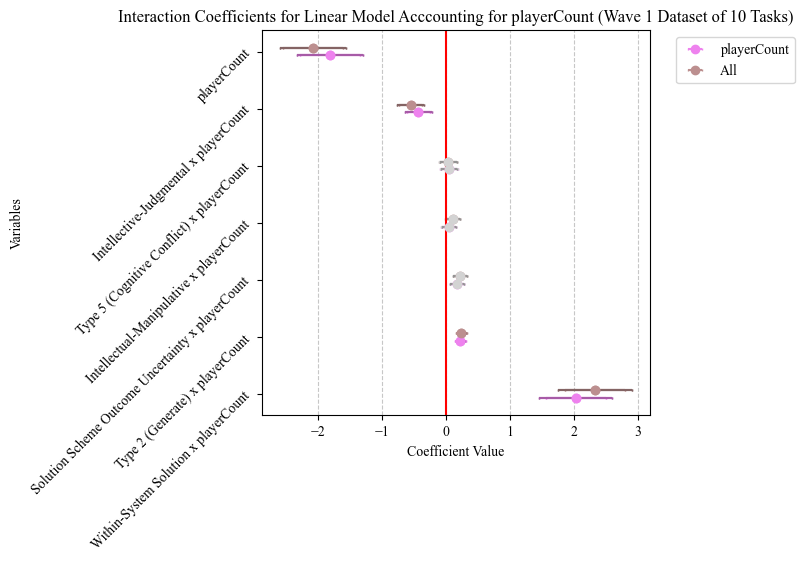

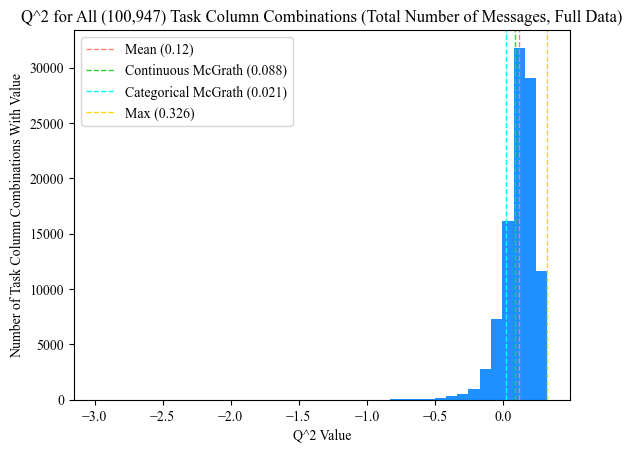

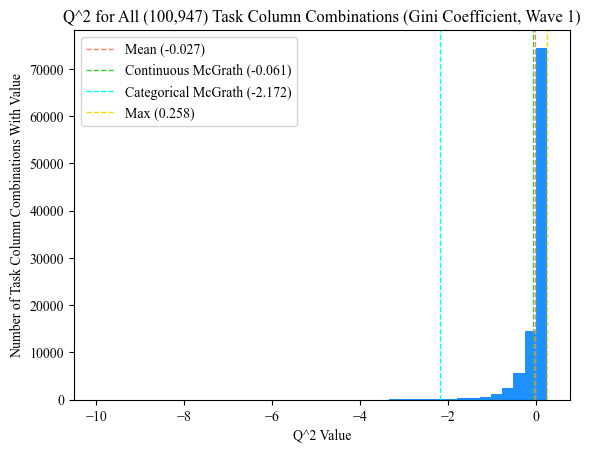

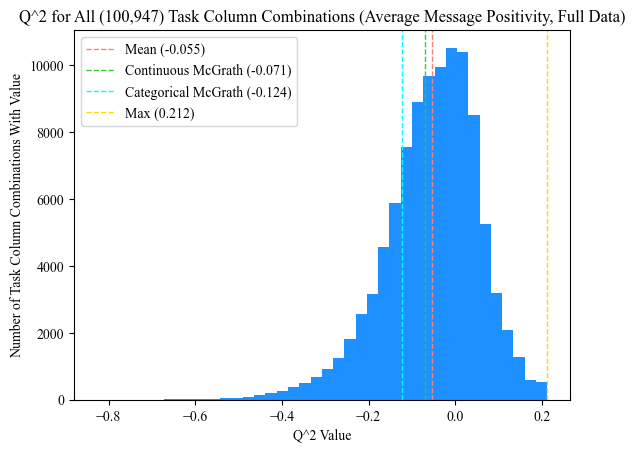

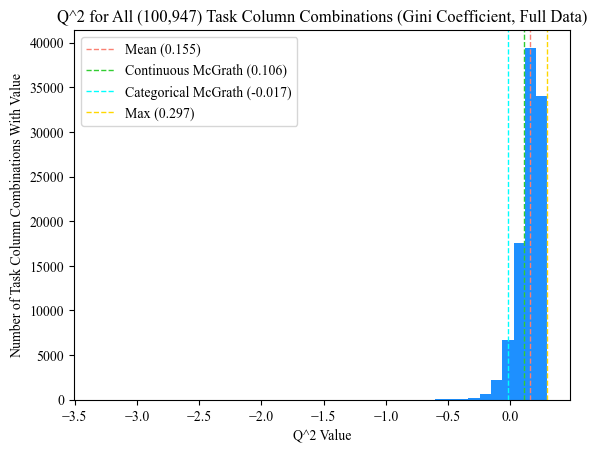

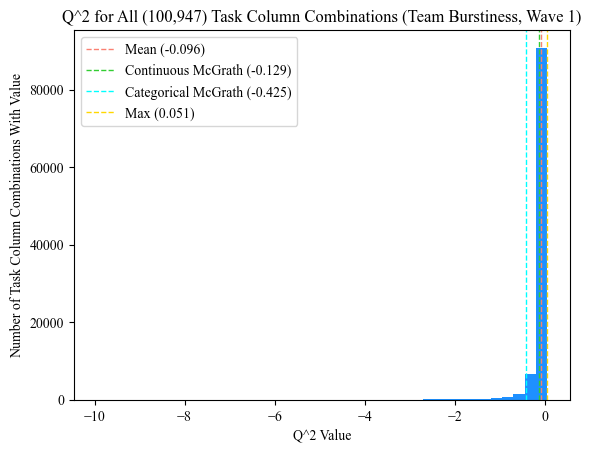

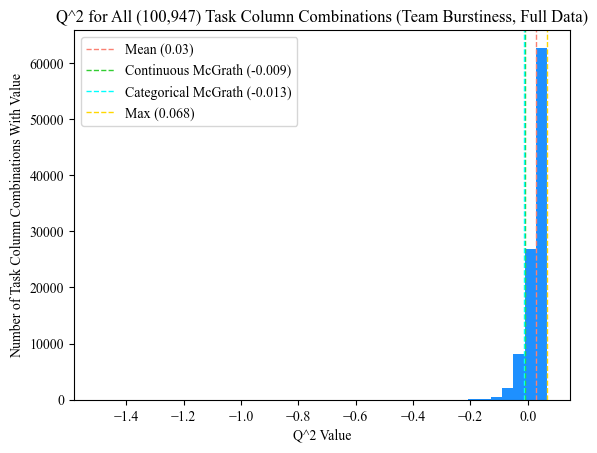

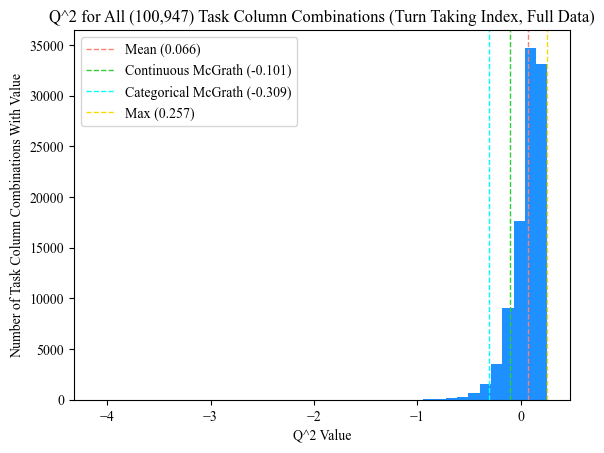

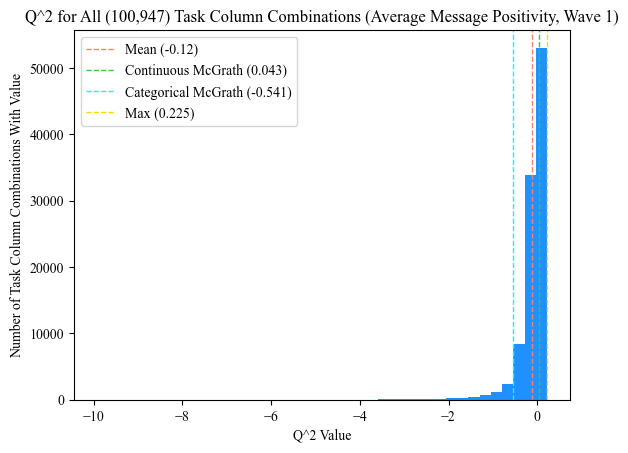

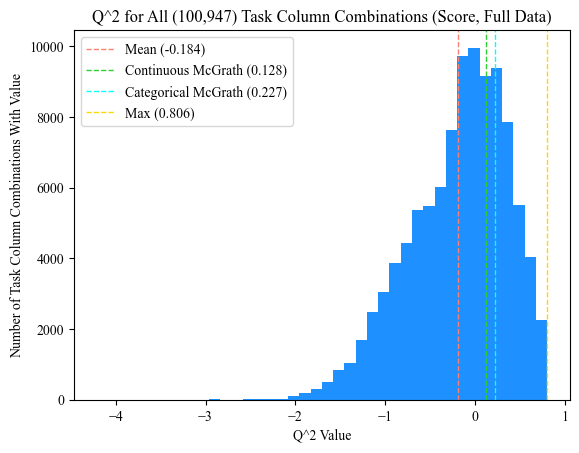

In [73]:
# read in the Q^2 exhaustive search results
# q2_results_path = "./sample_q2_exhaustive_search_outs"
q2_results_path = "./q2_exhaustive_search_outs"
# get all of the filenames in this path
q2_results_files = glob.glob(q2_results_path + "/*.csv")
for file in q2_results_files:
    filename = str(file).split("/")[-1]
    try:
        results_df = pd.read_csv(file)
    except: # handle cases where there is an EOF in the file
        delete_last_line(file)
        results_df = pd.read_csv(file)

    # get the top features and the Q^2 values associated with it
    maxq2_task_cols = list(ast.literal_eval(results_df.iloc[results_df["q2"].idxmax()]["selected_task_cols"]))
    maxq2_value = np.float64(results_df.iloc[results_df["q2"].idxmax()]["q2"])

    # get basic info: number features, whether it's full or wave1, and the dv
    filename_split = filename.split("/")[-1].split("_")
    num_features = int(filename_split[0])
    is_full = False
    dataset_append = "Wave 1"
    if("FULL" in filename):
        is_full = True
        dataset_append = "Full Data"
   
    # dv
    dv = re.sub("^[0-9]*_", "", filename)
    dv = re.sub("_q2_OLS_from_diff_task_cols_1", "", dv)
    dv = re.sub("_q2_OLS_from_diff_task_cols", "", dv)
    dv = re.sub("_FULL", "", dv)
    dv = re.sub(".csv", "", dv)

    # Check that the results_df is complete, and fill out the rest otherwise
    results_df = check_and_complete_exhaustive_search(results_df, num_features, dv, is_full, file)

    # Save the top features and the Q^2 values associated with those top features
    if dv not in top_features_dict.keys():
        top_features_dict[dv] = {}
    if num_features not in top_features_dict[dv].keys():
        top_features_dict[dv][num_features] = {"full": {}, "wave1": {}}

    if is_full:
        top_features_dict[dv][num_features]["full"] = {"features": maxq2_task_cols, "q2": maxq2_value, "df": results_df}
    else:
        top_features_dict[dv][num_features]["wave1"] = {"features": maxq2_task_cols, "q2": maxq2_value, "df": results_df}

    """
    Once we have all the necessary information, we do the following:
    1. Plot "us vs. McGrath" if num_features == 6
    2. Get the set of best-performing features
    3. Fit a linear model with the best-performing features and report Q^2
    4. Fit versions of the linear model with CRT, RME, and playerCount (if num_features == 6?)
    5. Print and Plot the Coefficients for 5 models: 
        (1) task features, 
        (2) task features + CRT, 
        (3) task features + RME, 
        (4) task features + playerCount, 
        (5) task features + CRT + RME + playerCount
    """
    if dv == "score":
        # this is the dataset without conversational features
        if is_full:
            data = team_multi_task_full
            data_composition = team_multi_task_full_with_composition
            mcgrath_comparison = mcgrath_comparisons_full
        else:
            data = team_multi_task_wave1
            data_composition = team_multi_task_wave1_with_composition
            mcgrath_comparison = mcgrath_comparisons_wave1

        # Plot us vs. McGrath
        if(num_features == 6):
            plot_q2_combination_hist(results_df, mcgrath_comparison, "q2", dv, " (Score, " + dataset_append + ")")

        # Linear Models
        if(num_features == 6):
            # Get the interactions that specifically pertained to the task columns
            CRT_and_interactions = ["CRT"] 
            RME_and_interactions = ["RME"]
            playerCount_and_interactions = ["playerCount"]

            for task_col in maxq2_task_cols:
                CRT_and_interactions.append(task_col + " x " + "CRT")
                RME_and_interactions.append(task_col + " x " + "RME")
                playerCount_and_interactions.append(task_col + " x " + "playerCount")

            task_lm = sm.OLS(endog = data_composition["score"], exog=sm.add_constant(data_composition[maxq2_task_cols + controls])).fit()
            task_crt_lm = sm.OLS(endog = data_composition["score"], exog=sm.add_constant(data_composition[maxq2_task_cols + CRT_and_interactions + controls])).fit()
            task_rme_lm = sm.OLS(endog = data_composition["score"], exog=sm.add_constant(data_composition[maxq2_task_cols + RME_and_interactions + controls])).fit()
            task_playercount_lm = sm.OLS(endog = data_composition["score"], exog=sm.add_constant(data_composition[maxq2_task_cols + playerCount_and_interactions + controls])).fit()
            giant_lm = sm.OLS(endog = data_composition["score"], exog=sm.add_constant(data_composition[maxq2_task_cols + CRT_and_interactions + RME_and_interactions + playerCount_and_interactions + controls])).fit()
            
            task_lm, task_crt_lm, task_rme_lm, task_playercount_lm, giant_lm = correct_p_values(task_lm, task_crt_lm, task_rme_lm, task_playercount_lm, giant_lm)
  
            models = [task_lm, task_crt_lm, task_rme_lm, task_playercount_lm, giant_lm]
            print_likelihood_ratio_tests(*models)

            if is_full:
                title_append = " (Full Dataset of 20 Tasks)"
            else:
                title_append = " (Wave 1 Dataset of 10 Tasks)"

            plot_models(models, 
                features_to_plot = list(task_cols_to_use) + controls, 
                model_names=["Task Only", "CRT", "RME", "PlayerCount", "All"], 
                colors=['limegreen', 'salmon', 'deepskyblue', 'violet', 'rosybrown'], 
                title='Task Coefficients from Linear Models Account for CRT, RME, and PlayerCount' + title_append, 
                figsize = (5, 5))
            plot_models([task_crt_lm, giant_lm], 
                features_to_plot=CRT_and_interactions, 
                model_names=["CRT", "All"], 
                colors=['salmon', 'rosybrown'], 
                title='Interaction Coefficients for Linear Model Acccounting for CRT' + title_append, 
                figsize = (5, 5))
            plot_models([task_rme_lm, giant_lm], 
                features_to_plot=RME_and_interactions, 
                model_names=["RME", "All"], 
                colors=['deepskyblue', 'rosybrown'], 
                title='Interaction Coefficients for Linear Model Acccounting for RME' + title_append, 
                figsize = (5, 5))
            plot_models([task_playercount_lm, giant_lm], 
                features_to_plot=playerCount_and_interactions, 
                model_names=["playerCount", "All"], 
                colors=['violet', 'rosybrown'], 
                title='Interaction Coefficients for Linear Model Acccounting for playerCount' + title_append, 
                figsize = (5, 5))


    else:
        # this is the dataset WITH conversational features
        if is_full:
            data = team_multi_task_comms_full
            data_composition = team_multi_task_comms_full_with_composition
            mcgrath_comparison = mcgrath_comparisons_conv_full
        else:
            data = team_multi_task_comms_wave1
            data_composition = team_multi_task_comms_wave1_with_composition
            mcgrath_comparison = mcgrath_comparisons_conv_wave1

        # Plot us vs. McGrath
        if(num_features == 6):
            plot_q2_combination_hist(results_df, mcgrath_comparison, "q2", dv, " (" + comm_dv_translation[dv] + ", " + dataset_append + ")")

In [74]:
# Stargazer([task_lm, task_crt_lm, task_rme_lm, task_playercount_lm, giant_lm])

In [51]:
selected_features = top_features_dict['score'][3]['wave1']['features']

In [52]:
lm_best_features = sm.OLS(endog = team_multi_task_wave1_with_composition["score"], exog=sm.add_constant(team_multi_task_wave1_with_composition[selected_features])).fit()
Stargazer([lm_best_features])

# Take a look at a summary of our results

In [53]:
top_features_dict

{'gini_coefficient_sum_num_messages': {2: {'full': {'features': ['Within-System Solution',
     'Conflicting Tradeoffs'],
    'q2': 0.2928962560516818,
    'df':                                     selected_task_cols        q2
    0       ('Conceptual-Behavioral', 'Type 1 (Planning)')  0.243882
    1    ('Conceptual-Behavioral', 'Type 8 (Performance)')  0.185279
    2       ('Conceptual-Behavioral', 'Type 2 (Generate)')  0.237401
    3    ('Conceptual-Behavioral', 'Type 5 (Cognitive C...  0.168214
    4              ('Conceptual-Behavioral', 'Optimizing')  0.218435
    ..                                                 ...       ...
    248      ('Conflicting Tradeoffs', 'Creativity Input')  0.278671
    249   ('Eureka Question', 'Intellectual-Manipulative')  0.203168
    250            ('Eureka Question', 'Creativity Input')  0.169878
    251    ('Time Solvability', 'Intellective-Judgmental')  0.115769
    252  ('Type 3 and Type 4 (Objective Correctness)', ...  0.068619
    
    [253 

Plot the best predictive power (line graph) by the number of features

In [54]:
# for dv in ["score"] + COMMS_DVS:

#     score_q2_by_n_features = [top_features_dict[dv][i]['wave1']['q2'] for i in range(1, len(top_features_dict[dv].keys())+1)]

#     plt.plot(range(1, len(top_features_dict[dv].keys())+1), score_q2_by_n_features, marker='o')
#     plt.title("Q^2 by Number of Features Selected: " + dv)
#     plt.xlabel("Number of Features Selected")
#     plt.ylabel("Q^2 of Top-Performing Feature Set")
#     plt.show()

In [55]:
dv_mapping = {
    "score": "Score",
    "turn_taking_index": "Turn-Taking Index",
    "gini_coefficient_sum_num_messages": "Gini Coefficient (Equality of Airtime)",
    "sum_num_messages": "Total Number of Messages",
    "average_positive_bert": "Average Mesage Positivity",
    "team_burstiness": "Temporal Burstiness"
}

In [56]:
DVS =  ["turn_taking_index", "gini_coefficient_sum_num_messages", "sum_num_messages", "team_burstiness", "average_positive_bert", "score"]

In [57]:
def plot_model_performance(dataset = "full", center = "mean", ci = 95, max_num_features = len(top_features_dict[dv].keys())):

    # range(1, n) goes from 1 to n, exclusive of n, so we need to add 1
    max_num_features = max_num_features+1

    # Determine which dataset to use
    assert(dataset in {'wave1', 'full'})
    if dataset == 'full':
        title_append = "(Full Data; 20 Tasks)"
    else:
        title_append = "(Wave 1 Data; 10 Tasks)"

    # Determine which values to plot
    assert(center in {"mean", "median", "max"})

    plt.figure(figsize=(10, 6))
    for dv in ["score"] + COMMS_DVS: 
        
        # Determine what we want to plot
        if center == "mean":
            title_prepend = "Mean"
            center_to_plot = [np.mean(top_features_dict[dv][i][dataset]['df']['q2']) for i in range(1, max_num_features)]
        elif center == "median":
            title_prepend = "Median"
            center_to_plot = [np.median(top_features_dict[dv][i][dataset]['df']['q2']) for i in range(1, max_num_features)]
        elif center == "max":
            title_prepend = "Top-Performing"
            center_to_plot = [top_features_dict[dv][i][dataset]['q2'] for i in range(1, max_num_features)]       
        
        # Calculate the 95% CI
        lower_bound = [np.percentile(top_features_dict[dv][i][dataset]['df']['q2'], (100-ci)/2) for i in range(1, max_num_features)]
        upper_bound = [np.percentile(top_features_dict[dv][i][dataset]['df']['q2'], 100-(100-ci)/2) for i in range(1, max_num_features)]
        
        # Plot the 95% CI shaded around the median
        if center != "max":
            plt.fill_between(range(1, max_num_features), lower_bound, upper_bound, alpha=0.1)
        
        plt.plot(range(1, max_num_features), center_to_plot, marker='o', label=dv_mapping[dv])

    plt.xticks(range(1, max_num_features))
    plt.title(title_prepend + " Q^2 by Number of Features Selected " + title_append)
    plt.xlabel("Number of Features Selected")
    plt.ylabel("Q^2 of Feature Set (" + title_prepend + ")")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

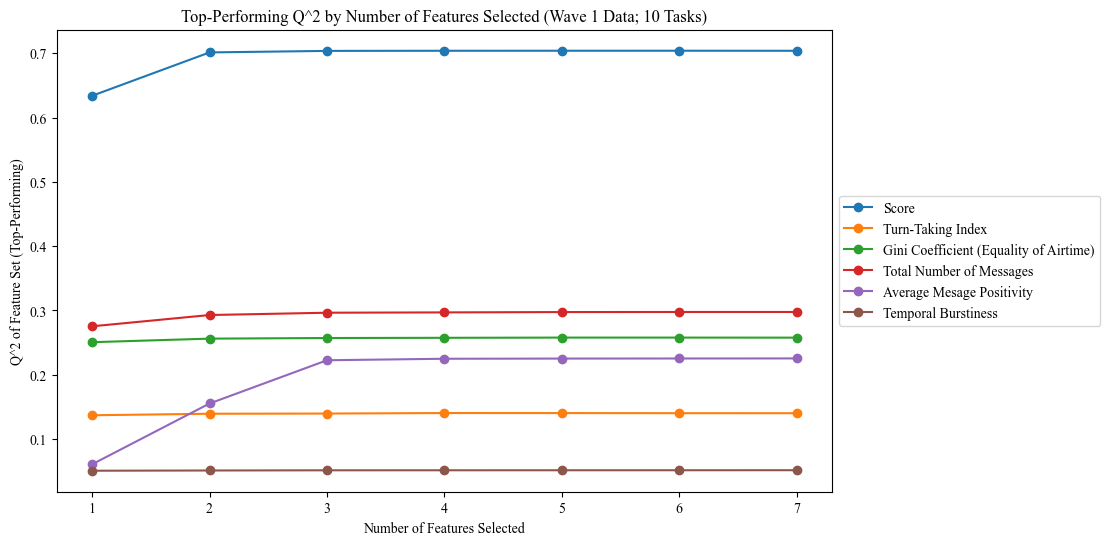

In [58]:
plot_model_performance(dataset = "wave1", center = "max", ci = 95, max_num_features=7)

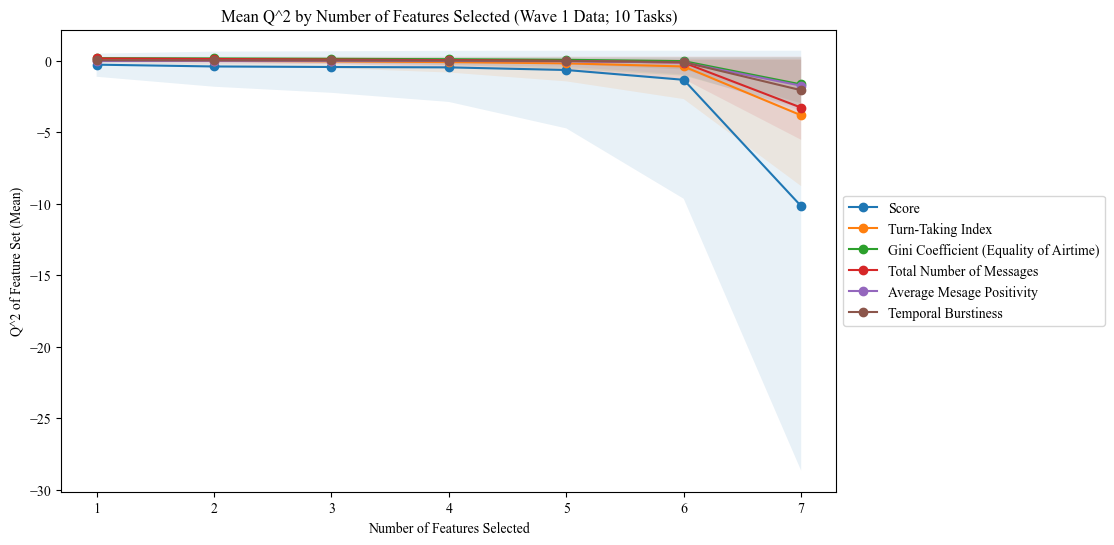

In [59]:
plot_model_performance(dataset = "wave1", center = "mean", ci = 95, max_num_features=7)

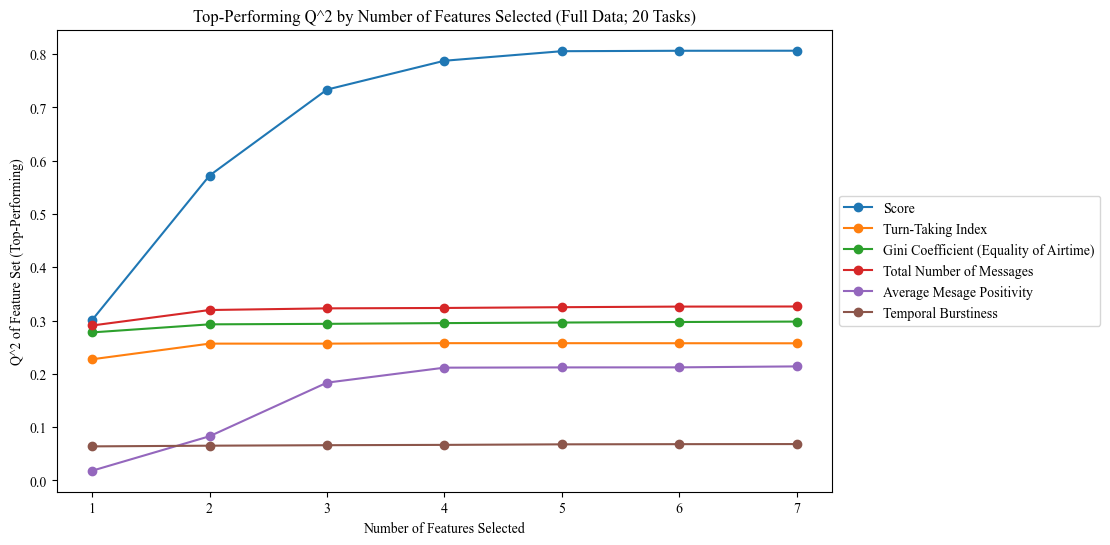

In [60]:
plot_model_performance(dataset = "full", center = "max", ci = 95, max_num_features=7)

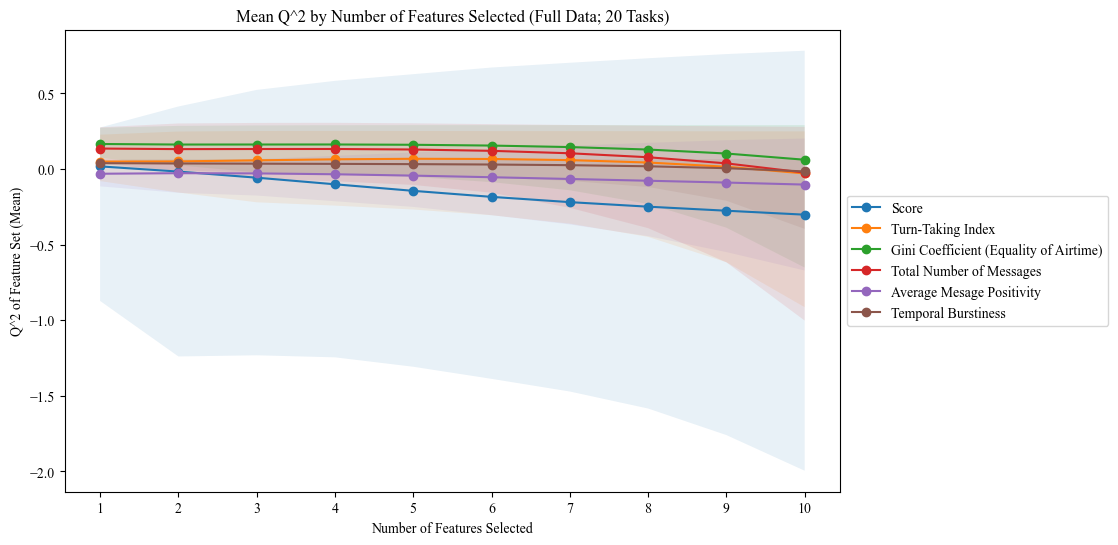

In [61]:
plot_model_performance(dataset = "full", center = "mean", ci = 95)

### Can we look at which features get added over time? (Bump Plot)

In [62]:
def get_features_over_num_features(top_features_dict, dv, dataset):
    num_features_range = range(1, len(top_features_dict[dv].keys()) + 1)
    features_over_num_features = {n: top_features_dict[dv][n][dataset]['features'] for n in num_features_range}
    return features_over_num_features

def plot_bump_chart(dataset, dv):
    # Determine which dataset to use
    assert(dataset in {'wave1', 'full'})
    if dataset == 'full':
        title_append = "(Full Data; 20 Tasks)"
    else:
        title_append = "(Wave 1 Data; 10 Tasks)"

    features_over_num_features = get_features_over_num_features(top_features_dict, dv, dataset)

    num_features_range = list(features_over_num_features.keys())
    all_features = set()
    for features in features_over_num_features.values():
        all_features.update(features)
    
    feature_to_y = {feature: -i for i, feature in enumerate(sorted(all_features))}
    
    plt.figure(figsize=(12, 8))

    # Plot the vertical lines for every x
    for n in num_features_range:
        plt.axvline(x=n, color='lightgray', linestyle='--', zorder=0)

    for n in num_features_range:
        for feature in features_over_num_features[n]:
            y = feature_to_y[feature]
            plt.scatter(n, y, color='blue', zorder=2)
    
    # Set y-axis labels
    y_ticks = list(feature_to_y.values())
    y_labels = list(feature_to_y.keys())
    plt.yticks(ticks=y_ticks, labels=y_labels)
    plt.xticks(num_features_range)
    
    plt.xlabel('Number of Features')
    plt.ylabel('Features')
    plt.title(dv_mapping[dv] + ': Feature Selection Bump Chart ' + title_append)
    plt.show()

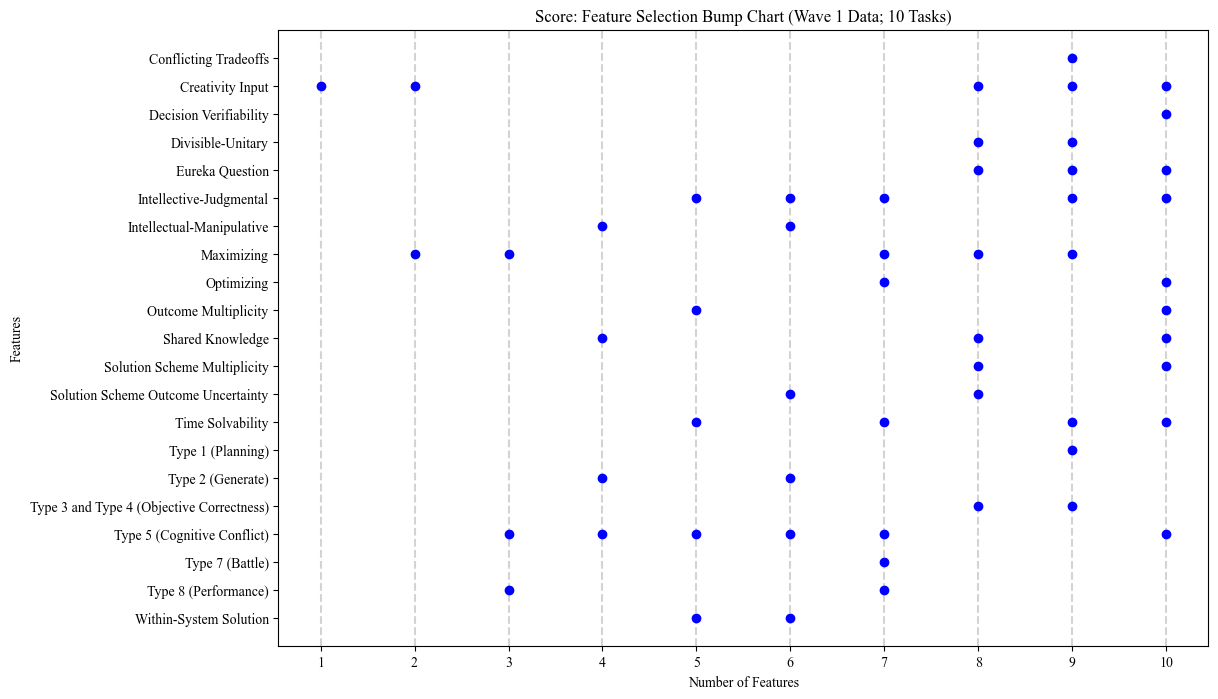

In [63]:
plot_bump_chart(dataset = "wave1", dv = "score")

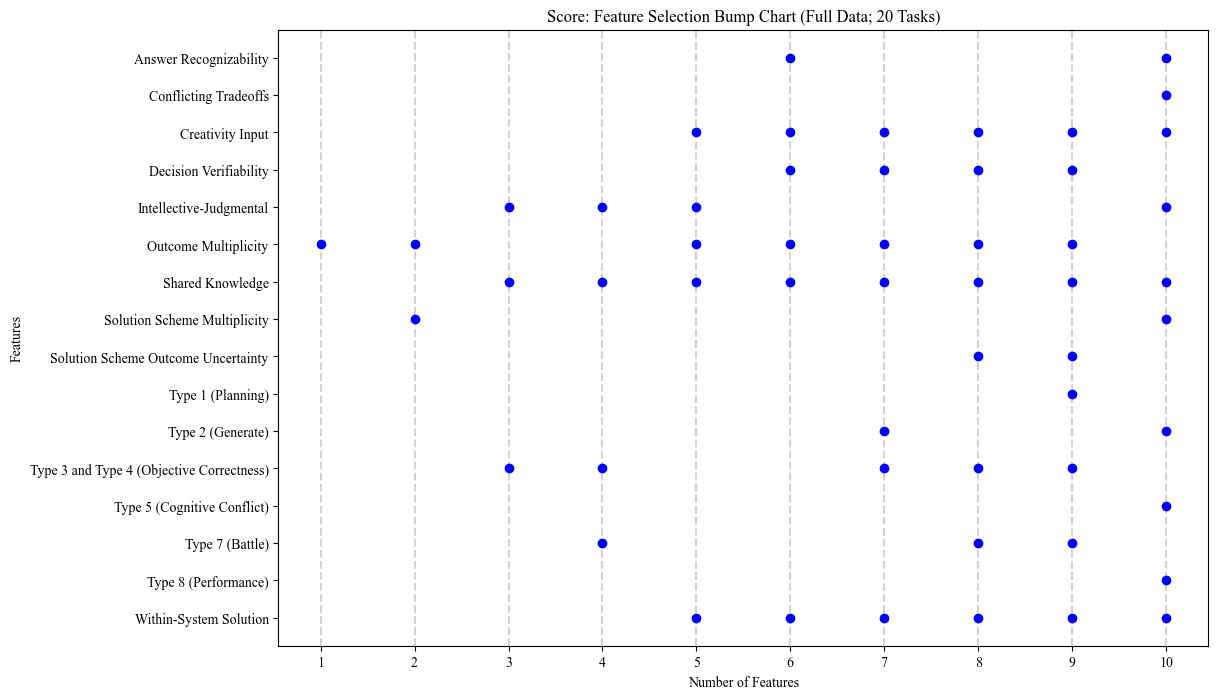

In [64]:
plot_bump_chart(dataset = "full", dv = "score")

### Can we look at the coefficients of the models for the different feature sets? 

In [65]:
def get_coefficients_depending_on_features(dv, dataset):
    assert(dataset in {'wave1', 'full'})
    assert(dv in DVS)

    if dv == "score":
        # this is the dataset without conversational features
        if dataset == "full":
            data = team_multi_task_full
            title_append = "(Full Data; 20 Tasks)"
        else:
            data = team_multi_task_wave1
            title_append = "(Wave 1 Data; 10 Tasks)"
    else:
        # this is the dataset WITH conversational features
        if dataset == "full":
            data = team_multi_task_comms_full
            title_append = "(Full Data; 20 Tasks)"
        else:
            data = team_multi_task_comms_wave1
            title_append = "(Wave 1 Data; 10 Tasks)"

    top_features = get_features_over_num_features(top_features_dict, dv, dataset)
    for i in range(1, len(top_features.keys())+1):
        # fit a linear regression model (OLS) and print out the coefficients
        lm_best_features = sm.OLS(endog = data[dv], exog=sm.add_constant(data[top_features[i]])).fit()
        print(lm_best_features.params)
        print("----")

In [66]:
# get_coefficients_depending_on_features(dv="score", dataset="full")

const                   1.830893e-17
Outcome Multiplicity    1.721434e-01
dtype: float64
----
const                           1.830893e-17
Outcome Multiplicity            4.847901e-01
Solution Scheme Multiplicity   -3.929304e-01
dtype: float64
----
const                                        1.830893e-17
Shared Knowledge                             1.085447e+00
Type 3 and Type 4 (Objective Correctness)    1.655198e+00
Intellective-Judgmental                     -2.587097e+00
dtype: float64
----
const                                        1.830893e-17
Type 7 (Battle)                             -1.623894e-01
Shared Knowledge                             1.290305e+00
Type 3 and Type 4 (Objective Correctness)    1.624415e+00
Intellective-Judgmental                     -2.684075e+00
dtype: float64
----
const                      1.830893e-17
Outcome Multiplicity       1.128083e+00
Shared Knowledge           5.893296e-01
Within-System Solution    -2.962383e-01
Intellective-Judgmental   -1.

### Is our measure of "Task A is closer to Task B" consistent?

In [67]:
def check_similarity_robustness_example_3_tasks(features, task_1 = "Moral Reasoning (Disciplinary Action Case)", task_2 = "Allocating resources to programs", task_3 = "Sudoku"):
    
    task_map_copy = task_map.copy()

    # filter down to a set of features
    task_map_copy = task_map_copy[["task_name"] + features]

    task_1_vec = np.asarray(task_map_copy[task_map_copy["task_name"] == task_1].drop("task_name",axis=1)).flatten()
    task_2_vec = np.asarray(task_map_copy[task_map_copy["task_name"] == task_2].drop("task_name",axis=1)).flatten()
    task_3_vec = np.asarray(task_map_copy[task_map_copy["task_name"] == task_3].drop("task_name",axis=1)).flatten()
    
    # get similarity between task 1 and task 2
    vec_1_2_sim = distance.cosine(task_1_vec, task_2_vec)
    vec_1_3_sim = distance.cosine(task_2_vec, task_3_vec)

    # 1 and 2 are closer than 1 and 3
    diff = vec_1_3_sim-vec_1_2_sim

    return(diff)

Do this experiment for 1 through 23 features

In [68]:
""""
 WANT TO SHOW:
 Two features that are farther away in a lower-dimensional representation of the space should also be
 further away in a higher dimensional representation of the space.

 HOW TO SHOW:
 - Choose every possible combination of 3 tasks.
 - Measure whether cosine_distance(task 1, task 2) is smaller than cosine_distance(task 1, task 3)
      - Positive if task 1 and task 2 are closer; Negative if 1 and 3 are closer
 - Ideally, all signs should be the same, so we'll return the % of signs that are the same

"""""
# consistency_dict_for_num_features = defaultdict(list)

# def process_tasks_for_combination(three_tasks, all_combinations_of_i_features):
#     try:
#         signs = []
#         for task_feature_combination in random.sample(all_combinations_of_i_features, 10):
#             diff = check_similarity_robustness_example_3_tasks(
#                 list(task_feature_combination), three_tasks[0], three_tasks[1], three_tasks[2]
#             )
#             signs.append(np.sign(diff))

#         # Compare the signs to 'perfect performance'
#         modal_sign = mode(signs)
#         consistency_pct = np.mean([(item == modal_sign) for item in signs])
#         return consistency_pct

#     except Exception as e:
#         print(f"Error processing tasks for combination {three_tasks}: {e}")
#         return None

# for i in range(2, 24):
#     print(f"Starting experiments for {i} features...")
    
#     all_combinations_of_i_features = list(itertools.combinations(task_map.drop("task_name", axis=1).columns, i))
#     all_three_task_combinations = list(itertools.combinations(task_map["task_name"].drop_duplicates(), 3))
    
#     with tqdm(total=len(all_three_task_combinations), desc=f"Processing {i} features") as pbar:
#         with concurrent.futures.ThreadPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
#             futures = [executor.submit(process_tasks_for_combination, three_tasks, all_combinations_of_i_features) 
#                        for three_tasks in all_three_task_combinations]
            
#             for future in concurrent.futures.as_completed(futures):
#                 result = future.result()
#                 if result is not None:
#                     consistency_dict_for_num_features[i].append(result)
#                 pbar.update()

# # Save the dictionary to a file
# with open('consistency_dict_for_num_features.pkl', 'wb') as file:
#     pickle.dump(consistency_dict_for_num_features, file)

Starting experiments for 2 features...


Processing 2 features: 100%|██████████| 171700/171700 [19:08<00:00, 149.56it/s]


Starting experiments for 3 features...


Processing 3 features: 100%|██████████| 171700/171700 [19:15<00:00, 148.66it/s]


Starting experiments for 4 features...


Processing 4 features: 100%|██████████| 171700/171700 [19:27<00:00, 147.01it/s]


Starting experiments for 5 features...


Processing 5 features: 100%|██████████| 171700/171700 [19:36<00:00, 145.94it/s]


Starting experiments for 6 features...


Processing 6 features: 100%|██████████| 171700/171700 [19:55<00:00, 143.61it/s]


Starting experiments for 7 features...


Processing 7 features: 100%|██████████| 171700/171700 [20:46<00:00, 137.77it/s]


Starting experiments for 8 features...


Processing 8 features: 100%|██████████| 171700/171700 [22:42<00:00, 125.97it/s] 


Starting experiments for 9 features...


Processing 9 features: 100%|██████████| 171700/171700 [48:50<00:00, 58.59it/s]   


Starting experiments for 10 features...


Processing 10 features: 100%|██████████| 171700/171700 [21:02<00:00, 135.97it/s]


Starting experiments for 11 features...


Processing 11 features: 100%|██████████| 171700/171700 [21:14<00:00, 134.76it/s]


Starting experiments for 12 features...


Processing 12 features: 100%|██████████| 171700/171700 [21:42<00:00, 131.85it/s]


Starting experiments for 13 features...


Processing 13 features: 100%|██████████| 171700/171700 [22:06<00:00, 129.44it/s]


Starting experiments for 14 features...


Processing 14 features: 100%|██████████| 171700/171700 [21:40<00:00, 132.02it/s]


Starting experiments for 15 features...


Processing 15 features: 100%|██████████| 171700/171700 [22:00<00:00, 130.03it/s]


Starting experiments for 16 features...


Processing 16 features: 100%|██████████| 171700/171700 [22:14<00:00, 128.68it/s]


Starting experiments for 17 features...


Processing 17 features: 100%|██████████| 171700/171700 [22:28<00:00, 127.32it/s]


Starting experiments for 18 features...


Processing 18 features: 100%|██████████| 171700/171700 [22:33<00:00, 126.82it/s]


Starting experiments for 19 features...


Processing 19 features: 100%|██████████| 171700/171700 [22:28<00:00, 127.33it/s]


Starting experiments for 20 features...


Processing 20 features: 100%|██████████| 171700/171700 [22:56<00:00, 124.70it/s]


Starting experiments for 21 features...


Processing 21 features: 100%|██████████| 171700/171700 [23:03<00:00, 124.07it/s]


Starting experiments for 22 features...


Processing 22 features: 100%|██████████| 171700/171700 [23:16<00:00, 122.92it/s]


Starting experiments for 23 features...


Processing 23 features: 100%|██████████| 171700/171700 [23:30<00:00, 121.69it/s]


Plot agreemeent over the number of features

In [69]:
with open('consistency_dict_for_num_features.pkl', 'rb') as file:
    consistency_dict_for_num_features = pickle.load(file)

# Initialize lists to store x-values (number of features), means, and CIs
num_features = []
means = []
lower_bounds = []
upper_bounds = []

# Calculate mean and 95% CI for each entry in the dictionary
for key, values in sorted(consistency_dict_for_num_features.items()):
    num_features.append(key)
    mean_val = np.mean(values)
    means.append(mean_val)
    
    # Calculate 95% CI
    n = len(values)
    if n > 1:  
        h = stats.sem(values) * stats.t.ppf((1 + 0.95) / 2, n - 1)
    else:
        h = 0  # In case of a single value, CI is zero (no spread)
    
    lower_bounds.append(mean_val - h)
    upper_bounds.append(mean_val + h)

In [71]:
means

[0.6397513104251602,
 0.7167099592312172,
 0.7523843913803145,
 0.7774513686662784,
 0.7974938846825858,
 0.8139149679673848,
 0.8285870704717532,
 0.8420827023878859,
 0.8538864298194525,
 0.8644321490972626,
 0.8750198019801981,
 0.8851461852067558,
 0.8949976703552709,
 0.9034076878276063,
 0.9126802562609201,
 0.9215165987186954,
 0.9303937099592311,
 0.9391939429237042,
 0.948735002912056,
 0.9584548631333719,
 0.9690728013977871,
 0.9816849155503786]

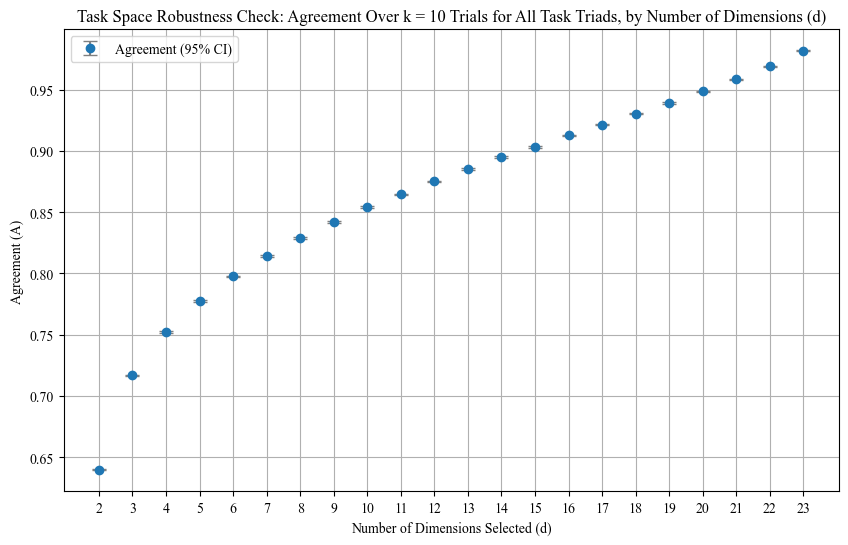

In [70]:
plt.figure(figsize=(10, 6))
plt.errorbar(num_features, means, yerr=[np.array(means) - np.array(lower_bounds), np.array(upper_bounds) - np.array(means)], 
             fmt='o', capsize=5, capthick=1, ecolor='gray', label='Agreement (95% CI)')
plt.xlabel('Number of Dimensions Selected (d)')
plt.ylabel('Agreement (A)')
plt.title('Task Space Robustness Check: Agreement Over k = 10 Trials for All Task Triads, by Number of Dimensions (d)')
plt.xticks(np.arange(min(num_features), max(num_features) + 1, 1))

plt.grid(True)
plt.legend()
plt.show()

## Plot one-off histograms (exploration)

In [142]:
def plot_q2_combination_hist_separate(file, col = "q2", title_append = ""):
    filename = str(file).split("/")[-1]
    df = pd.read_csv(file)

    # get basic info: number features, whether it's full or wave1, and the dv
    filename_split = filename.split("/")[-1].split("_")
    num_features = int(filename_split[0])
    dataset_append = "Wave 1"
    if("FULL" in filename):
        dataset_append = "Full Data"
   
    # dv
    dv = re.sub("^[0-9]*_", "", filename)
    dv = re.sub("_q2_OLS_from_diff_task_cols_1", "", dv)
    dv = re.sub("_q2_OLS_from_diff_task_cols", "", dv)
    dv = re.sub("_FULL", "", dv)
    dv = re.sub(".csv", "", dv)

    # keep the dataframe for metrics
    df_for_metrics =  df
    # when plotting, filter the dataframe so that we don't have huge negative values
    df = df[df[col] > -10]
    
    plt.hist(df[col], bins=40, color="dodgerblue")

    # Vertical lines
    median_q2 = np.median(df_for_metrics[col]) # df for metrics is where we'll calculate the median / max from, but we'll plot the df (in case there's a long tail)
    max_q2 = np.max(df_for_metrics[col])

    if(median_q2 > -10): # hacky way to ensure we see it on the plot
        plt.axvline(median_q2, color='salmon', linestyle='dashed', linewidth=1, label='Median (' + str(np.round(median_q2, 3)) + ")")
    plt.axvline(max_q2, color='gold', linestyle='dashed', linewidth=1, label='Max (' + str(np.round(max_q2, 3)) + ")")

    # Labels and title
    plt.title(f'Q^2 for All ({len(df_for_metrics):,}) Combinations of {num_features} Task Columns ({dv}, {dataset_append}){title_append}')
    plt.ylabel('Number of Task Column Combinations With Value')
    plt.xlabel('Q^2 Value')

    # Legend
    plt.legend()

    # Show plot
    plt.show()

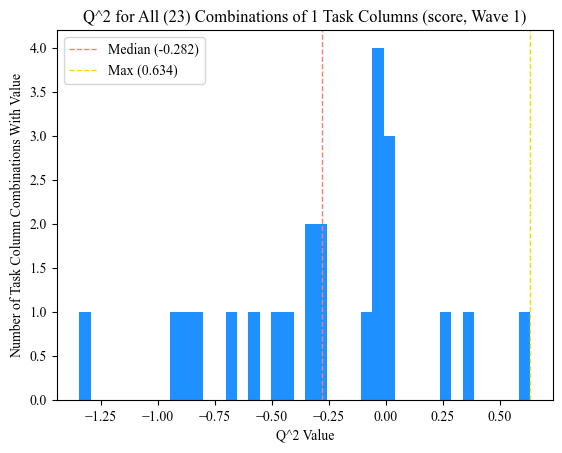

In [143]:
plot_q2_combination_hist_separate(q2_results_path + "/1_score_q2_OLS_from_diff_task_cols.csv")

In [144]:
top_features_dict['score'][1]['wave1']['features']

['Creativity Input']

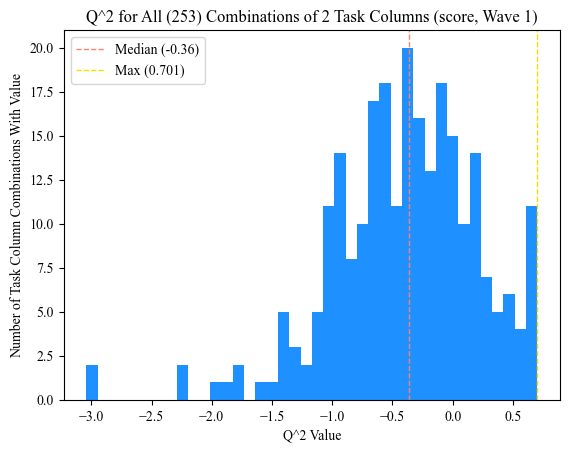

In [145]:
plot_q2_combination_hist_separate(q2_results_path + "/2_score_q2_OLS_from_diff_task_cols.csv")

In [146]:
top_features_dict['score'][2]['wave1']['features']

['Maximizing', 'Creativity Input']

### Among the best-performing 3-feature combinations, how many contain the top 2 features?

In [147]:
df3 = pd.read_csv(q2_results_path + "/3_score_q2_OLS_from_diff_task_cols.csv")
df3 = df3[df3["q2"] > 0.7]
best_2 = top_features_dict['score'][2]['wave1']['features']
counter = 0
for col in df3["selected_task_cols"]:
    lst = ast.literal_eval(col)
    if(len(set(best_2).intersection(set(lst)))) > 0:
        counter+=1
print(counter/len(df3))

0.9333333333333333


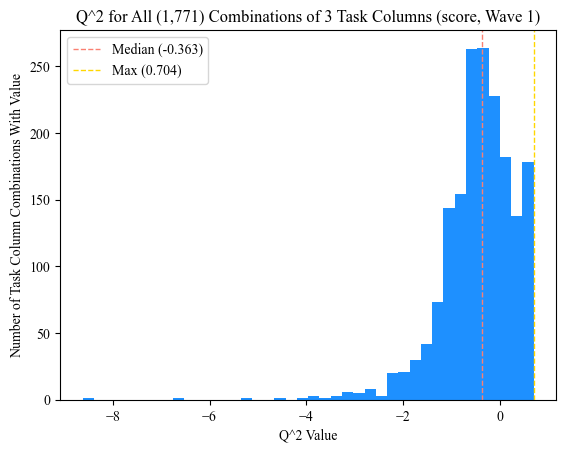

In [148]:
plot_q2_combination_hist_separate(q2_results_path + "/3_score_q2_OLS_from_diff_task_cols.csv")

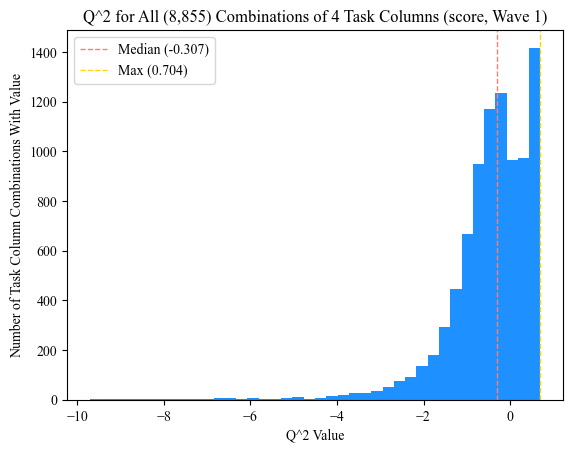

In [149]:
plot_q2_combination_hist_separate(q2_results_path + "/4_score_q2_OLS_from_diff_task_cols.csv")

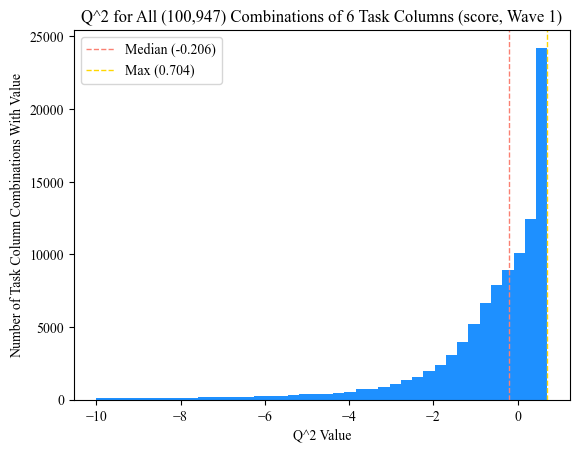

In [150]:
plot_q2_combination_hist_separate(q2_results_path + "/6_score_q2_OLS_from_diff_task_cols.csv")

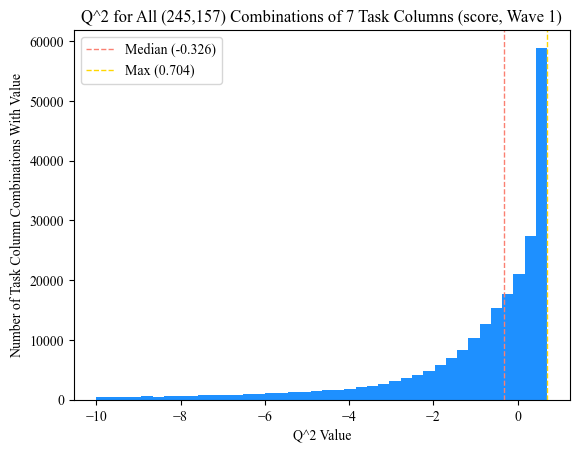

In [151]:
plot_q2_combination_hist_separate(q2_results_path + "/7_score_q2_OLS_from_diff_task_cols.csv")

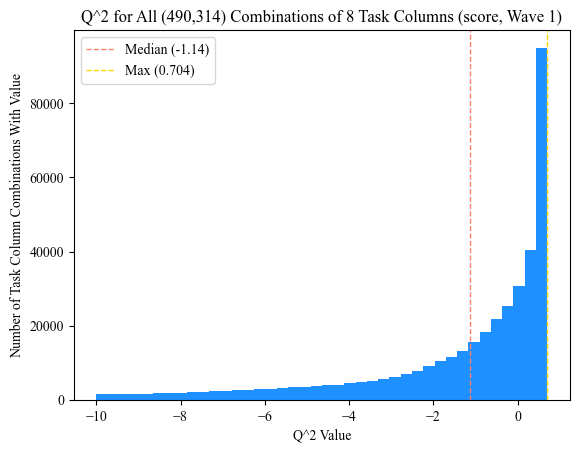

In [152]:
plot_q2_combination_hist_separate(q2_results_path + "/8_score_q2_OLS_from_diff_task_cols.csv")

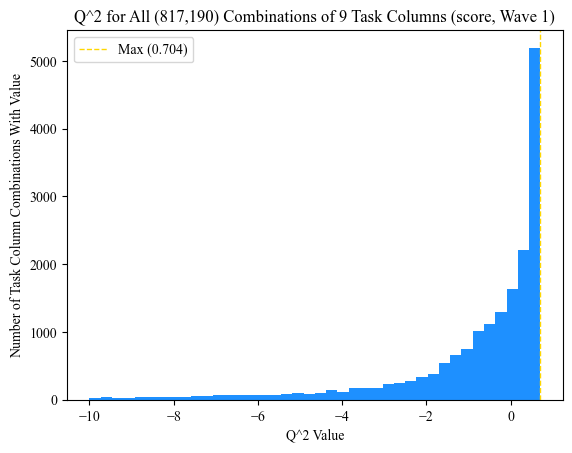

In [153]:
# apparently the tail is so long that the median doesn't show up on the plot
plot_q2_combination_hist_separate(q2_results_path + "/9_score_q2_OLS_from_diff_task_cols_1.csv")

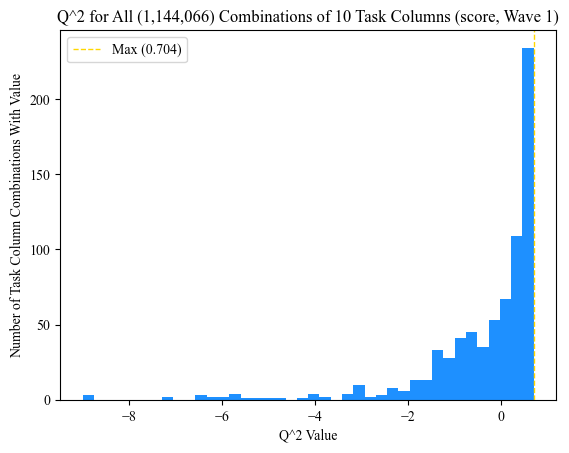

In [154]:
plot_q2_combination_hist_separate(q2_results_path + "/10_score_q2_OLS_from_diff_task_cols_1.csv")

## Compare features and Q^2 selected for a given feature set size

In [156]:
def get_top_features(feat_num_to_select, dataset_type):
    assert(dataset_type in ["full", "wave1"])

    features_for_each_dv = []
    
    for dv in DVS:
        try:
            features = top_features_dict[dv][feat_num_to_select][dataset_type]['features']
        except KeyError:
            features = None  # Or any default value you'd prefer
        features_for_each_dv.append(features)
        
    df_features_for_each_dv = pd.DataFrame(features_for_each_dv, index=DVS).T
    return df_features_for_each_dv

In [157]:
def get_top_q2_performance(feat_num_to_select, dataset_type):
    assert(dataset_type in ["full", "wave1"])

    q2_for_each_dv = []

    for dv in DVS:
        try:
            q2 = round(top_features_dict[dv][feat_num_to_select][dataset_type]['q2'], 3)
        except KeyError:
            q2 = None  # Or any default value you'd prefer
        q2_for_each_dv.append(q2)
    
    df_q2_for_each_dv = pd.DataFrame(q2_for_each_dv, index=DVS).T
    return df_q2_for_each_dv

In [158]:
top_features_dict

{'gini_coefficient_sum_num_messages': {2: {'full': {'features': ['Within-System Solution',
     'Conflicting Tradeoffs'],
    'q2': 0.2928962560516818,
    'df':                                     selected_task_cols        q2
    0       ('Conceptual-Behavioral', 'Type 1 (Planning)')  0.243882
    1    ('Conceptual-Behavioral', 'Type 8 (Performance)')  0.185279
    2       ('Conceptual-Behavioral', 'Type 2 (Generate)')  0.237401
    3    ('Conceptual-Behavioral', 'Type 5 (Cognitive C...  0.168214
    4              ('Conceptual-Behavioral', 'Optimizing')  0.218435
    ..                                                 ...       ...
    248      ('Conflicting Tradeoffs', 'Creativity Input')  0.278671
    249   ('Eureka Question', 'Intellectual-Manipulative')  0.203168
    250            ('Eureka Question', 'Creativity Input')  0.169878
    251    ('Time Solvability', 'Intellective-Judgmental')  0.115769
    252  ('Type 3 and Type 4 (Objective Correctness)', ...  0.068619
    
    [253 

In [159]:
get_top_features(2, "wave1")

,turn_taking_index,gini_coefficient_sum_num_messages,sum_num_messages,team_burstiness,average_positive_bert,score
0,Divisible-Unitary,Conceptual-Behavioral,Divisible-Unitary,Conceptual-Behavioral,Type 7 (Battle),Maximizing
1,Eureka Question,Type 2 (Generate),Conflicting Tradeoffs,Divisible-Unitary,Conflicting Tradeoffs,Creativity Input


In [160]:
get_top_features(7, "full")

,turn_taking_index,gini_coefficient_sum_num_messages,sum_num_messages,team_burstiness,average_positive_bert,score
0,Type 2 (Generate),Conceptual-Behavioral,Conceptual-Behavioral,Conceptual-Behavioral,Conceptual-Behavioral,Type 2 (Generate)
1,Type 8 (Performance),Type 1 (Planning),Outcome Multiplicity,Type 7 (Battle),Type 1 (Planning),Outcome Multiplicity
2,Time Solvability,Divisible-Unitary,Answer Recognizability,Outcome Multiplicity,Outcome Multiplicity,Decision Verifiability
3,Type 3 and Type 4 (Objective Correctness),Outcome Multiplicity,Conflicting Tradeoffs,Time Solvability,Shared Knowledge,Shared Knowledge
4,Conflicting Tradeoffs,Answer Recognizability,Intellectual-Manipulative,Conflicting Tradeoffs,Time Solvability,Within-System Solution
5,Solution Scheme Outcome Uncertainty,Intellectual-Manipulative,Intellective-Judgmental,Intellectual-Manipulative,Eureka Question,Type 3 and Type 4 (Objective Correctness)
6,Creativity Input,Creativity Input,Creativity Input,Creativity Input,Creativity Input,Creativity Input


In [161]:
get_top_q2_performance(7, "full")

,turn_taking_index,gini_coefficient_sum_num_messages,sum_num_messages,team_burstiness,average_positive_bert,score
0,0.257,0.298,0.326,0.068,0.214,0.807


In [162]:
get_top_q2_performance(8, "full")

,turn_taking_index,gini_coefficient_sum_num_messages,sum_num_messages,team_burstiness,average_positive_bert,score
0,0.257,0.299,0.327,0.068,0.214,0.807


In [163]:
get_top_q2_performance(9, "full")

,turn_taking_index,gini_coefficient_sum_num_messages,sum_num_messages,team_burstiness,average_positive_bert,score
0,0.257,0.299,0.328,0.068,0.214,0.807


In [164]:
get_top_q2_performance(10, "full")

,turn_taking_index,gini_coefficient_sum_num_messages,sum_num_messages,team_burstiness,average_positive_bert,score
0,0.257,0.299,0.329,0.068,0.214,0.807


In [165]:
get_top_features(6, "full")

,turn_taking_index,gini_coefficient_sum_num_messages,sum_num_messages,team_burstiness,average_positive_bert,score
0,Type 2 (Generate),Conceptual-Behavioral,Conceptual-Behavioral,Conceptual-Behavioral,Outcome Multiplicity,Outcome Multiplicity
1,Solution Scheme Multiplicity,Outcome Multiplicity,Outcome Multiplicity,Type 5 (Cognitive Conflict),Shared Knowledge,Decision Verifiability
2,Shared Knowledge,Conflicting Tradeoffs,Answer Recognizability,Outcome Multiplicity,Within-System Solution,Shared Knowledge
3,Time Solvability,Intellectual-Manipulative,Conflicting Tradeoffs,Time Solvability,Answer Recognizability,Within-System Solution
4,Type 3 and Type 4 (Objective Correctness),Intellective-Judgmental,Intellectual-Manipulative,Intellectual-Manipulative,Conflicting Tradeoffs,Answer Recognizability
5,Conflicting Tradeoffs,Creativity Input,Creativity Input,Creativity Input,Creativity Input,Creativity Input


In [166]:
get_top_q2_performance(6, "full")

,turn_taking_index,gini_coefficient_sum_num_messages,sum_num_messages,team_burstiness,average_positive_bert,score
0,0.257,0.297,0.326,0.068,0.212,0.806


In [167]:
get_top_features(7, "wave1")

,turn_taking_index,gini_coefficient_sum_num_messages,sum_num_messages,team_burstiness,average_positive_bert,score
0,Type 1 (Planning),Type 5 (Cognitive Conflict),Type 1 (Planning),Type 5 (Cognitive Conflict),Type 1 (Planning),Type 5 (Cognitive Conflict)
1,Type 8 (Performance),Type 7 (Battle),Optimizing,Divisible-Unitary,Type 2 (Generate),Type 7 (Battle)
2,Divisible-Unitary,Shared Knowledge,Outcome Multiplicity,Solution Scheme Multiplicity,Outcome Multiplicity,Type 8 (Performance)
3,Time Solvability,Answer Recognizability,Shared Knowledge,Decision Verifiability,Conflicting Tradeoffs,Maximizing
4,Type 3 and Type 4 (Objective Correctness),Solution Scheme Outcome Uncertainty,Type 3 and Type 4 (Objective Correctness),Shared Knowledge,Solution Scheme Outcome Uncertainty,Optimizing
5,Eureka Question,Eureka Question,Conflicting Tradeoffs,Time Solvability,Eureka Question,Time Solvability
6,Creativity Input,Intellective-Judgmental,Creativity Input,Intellective-Judgmental,Creativity Input,Intellective-Judgmental


In [168]:
get_top_q2_performance(9, "wave1")

,turn_taking_index,gini_coefficient_sum_num_messages,sum_num_messages,team_burstiness,average_positive_bert,score
0,0.135,0.256,0.297,0.05,0.224,0.704


In [169]:
get_top_q2_performance(8, "wave1")

,turn_taking_index,gini_coefficient_sum_num_messages,sum_num_messages,team_burstiness,average_positive_bert,score
0,0.135,0.256,0.297,0.05,0.224,0.704


In [170]:
get_top_q2_performance(7, "wave1")

,turn_taking_index,gini_coefficient_sum_num_messages,sum_num_messages,team_burstiness,average_positive_bert,score
0,0.14,0.258,0.298,0.051,0.225,0.704


In [171]:
get_top_q2_performance(6, "wave1")

,turn_taking_index,gini_coefficient_sum_num_messages,sum_num_messages,team_burstiness,average_positive_bert,score
0,0.14,0.258,0.298,0.051,0.225,0.704


In [172]:
get_top_q2_performance(3, "wave1")

,turn_taking_index,gini_coefficient_sum_num_messages,sum_num_messages,team_burstiness,average_positive_bert,score
0,0.14,0.257,0.296,0.051,0.222,0.704


In [173]:
get_top_q2_performance(2, "wave1")

,turn_taking_index,gini_coefficient_sum_num_messages,sum_num_messages,team_burstiness,average_positive_bert,score
0,0.139,0.256,0.293,0.051,0.155,0.701


In [174]:
get_top_q2_performance(1, "wave1")

,turn_taking_index,gini_coefficient_sum_num_messages,sum_num_messages,team_burstiness,average_positive_bert,score
0,0.137,0.251,0.275,0.051,0.061,0.634


In [175]:
get_top_features(6, "wave1")

,turn_taking_index,gini_coefficient_sum_num_messages,sum_num_messages,team_burstiness,average_positive_bert,score
0,Type 2 (Generate),Type 7 (Battle),Type 1 (Planning),Conceptual-Behavioral,Outcome Multiplicity,Type 2 (Generate)
1,Divisible-Unitary,Outcome Multiplicity,Outcome Multiplicity,Type 2 (Generate),Shared Knowledge,Type 5 (Cognitive Conflict)
2,Outcome Multiplicity,Conflicting Tradeoffs,Decision Verifiability,Type 5 (Cognitive Conflict),Conflicting Tradeoffs,Within-System Solution
3,Answer Recognizability,Solution Scheme Outcome Uncertainty,Shared Knowledge,Outcome Multiplicity,Eureka Question,Solution Scheme Outcome Uncertainty
4,Type 3 and Type 4 (Objective Correctness),Eureka Question,Type 3 and Type 4 (Objective Correctness),Time Solvability,Intellective-Judgmental,Intellectual-Manipulative
5,Creativity Input,Creativity Input,Conflicting Tradeoffs,Intellective-Judgmental,Creativity Input,Intellective-Judgmental
